In [1]:
import sys
sys.path.append("..")
import sem_utils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import pymc3 as pm
#### Bayesian estimation using PyMC3
def bayes_ar_one_model(corr, progress=False):
    with pm.Model() as ar1:
        k_ = pm.Uniform('k',-1,1) #we assume process is stationary, so -1<k_<1
        tau_ = pm.Gamma('tau',mu=1,sd=1)
        center = pm.Normal('center', mu=corr.mean(), sigma=5) #set the prior for the true mean to be centred on the population mean
        likelihood = pm.AR1('likelihood', k=k_, tau_e=tau_, observed=corr-center)
        trace = pm.sample(progressbar=progress)
    return trace

In [3]:
def sem_from_bayesian_estimation(timeseries, progress=False):
    trace = bayes_ar_one_model(timeseries, progress=progress)
    hpd = pm.stats.hpd(trace['center'],credible_interval=0.95)
    #this averages the hpd into a SEM. May not be as accurate.
    #hpd_sem = (hpd[1]-hpd[0]/2)/1.96
    #return hpd_sem
    ##this returns the exact HPD:
    return hpd[0], hpd[1]

0.33863610422540563


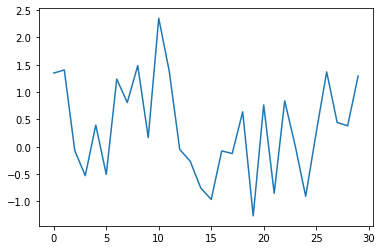

In [48]:
curve = sem_utils.gen_correlated_curve(0.3, 30)
print(np.mean(curve))
plt.plot(curve)

In [8]:
curve =sem_utils.gen_correlated_curve(0.99, 5000000)

In [10]:
sizes = [10,30,100,300,1000,3000,10000,30000,100000,300000,1000000]
gs = list()
for size in sizes:
    print(size)
    gs.append(sem_utils.statistical_inefficiency(curve[:size]))

10
30
100
300
1000
3000
10000
30000
100000
300000
1000000


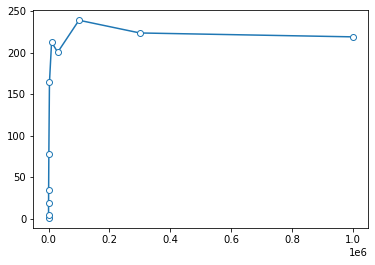

In [13]:
plt.plot(sizes, gs, '-o', mfc='white')

In [21]:
pm.stats.hpd(trace['center'],credible_interval=0.95)

array([-0.68650101,  0.64193803])

In [17]:
gs[-1] / (-1/np.log(0.99))

2.200117527719566

In [44]:
ac= 0.99
curve = sem_utils.gen_correlated_curve(ac, int(1e6))

g = sem_utils.statistical_inefficiency(curve)
print(g / (-1/np.log(ac)))
print(g /(-np.log(2) / np.log(ac)))

1.971832349141938
2.844752751571509


In [45]:
(-1/np.log(ac))

99.49916247342207

In [47]:
(-np.log(2) / np.log(ac))

68.96756393652842

In [46]:
(g-1)/2

97.59783363881161

In [30]:
(-np.log(2) / np.log(0.99))

68.96756393652842

# Compare a few techniques for calculating the SEM.


In [42]:
timeseries_lengths = np.array([30,100,300,1000,3000])

timeseries_rhos = np.array([0.1, 0.3, 0.5, 0.7, 0.9])

numrpts = 10


In [43]:
method_names = ['BlockAveraging', 'Chodera', 'Sokal', 'AR1_correction', 'AR1_Bayes']
method_functions = [sem_utils.sem_from_blockAveraging,
                    sem_utils.sem_from_chodera,
                    sem_utils.sem_from_sokal, 
                    sem_utils.sem_from_autoregressive_correction,
                    sem_utils.sem_from_bayesian_estimation]


df = pd.DataFrame(columns=['methodName', 'trueRho', 'timeSeriesLength', 'estMean', 'SEM'])
row_num = 0

for rho in timeseries_rhos:
    for datasize in timeseries_lengths:
        for rpt in range(numrpts):
            timeseries = sem_utils.gen_correlated_curve(rho, datasize)
            estimated_mean = timeseries.mean()
            
            for methodName, function in zip(method_names, method_functions):
                sem = function(timeseries)
                results = [methodName, rho, datasize, estimated_mean, sem]
                print(results)
                df.loc[row_num] = results
                row_num += 1
                

df.to

In [45]:
df.to_csv('sem_results.csv')

# checking output:


In [22]:
import sem_utils

import numpy as np
import pandas as pd


np.random.seed(457840)

##setup search parameters:
timeseries_lengths = np.array([30,100,300,1000,3000])
timeseries_rhos = np.array([0.1, 0.3, 0.5, 0.7, 0.9, 0.99])
numrpts = 100


##setup names and estimation functions
method_names = ['Naive', 'BlockAveraging', 'Chodera', 'Sokal', 'AR1_correction']
method_functions = [sem_utils.sem_from_independent,
                    sem_utils.sem_from_blockAveraging,
                    sem_utils.sem_from_chodera,
                    sem_utils.sem_from_sokal,
                    sem_utils.sem_from_autoregressive_correction,
                    sem_utils.sem_from_bayesian_estimation]

##setup df to store the results (we are using long format here due to the complicated structure of the search grid)
df = pd.DataFrame(columns=['methodName', 'trueRho', 'timeSeriesLength', 'estMean', 'mean_low', 'mean_high'])
row_num = 0

##do the measurements:
for rho in timeseries_rhos:
    for datasize in timeseries_lengths:
        for rpt in range(numrpts):
            timeseries = sem_utils.gen_correlated_curve(rho, datasize)
            estimated_mean = timeseries.mean()

            for methodName, function in zip(method_names, method_functions):
                mean_low, mean_high = function(timeseries)
                results = [methodName, rho, datasize, estimated_mean, mean_low, mean_high]
                print(results)
                df.loc[row_num] = results
                row_num += 1

##save the csv file:

['Naive', 0.1, 30, 0.0906530126342512, -0.27899831477293036, 0.4603043400414327]
['BlockAveraging', 0.1, 30, 0.0906530126342512, -0.25330256582526745, 0.4346085910937698]
['Chodera', 0.1, 30, 0.0906530126342512, -0.2727852449264542, 0.45409127019495654]
['Sokal', 0.1, 30, 0.0906530126342512, -0.11280581089389326, 0.29411183616239567]
['AR1_correction', 0.1, 30, 0.0906530126342512, -0.3559266110359188, 0.5372326363044212]
['Naive', 0.1, 30, 0.16723524156514014, -0.2117632741341378, 0.546233757264418]
['BlockAveraging', 0.1, 30, 0.16723524156514014, -0.09017364659627197, 0.42464412972655224]
['Chodera', 0.1, 30, 0.16723524156514014, -0.20539309749696155, 0.5398635806272418]
['Sokal', 0.1, 30, 0.16723524156514014, 0.09451865763841437, 0.2399518254918659]
['AR1_correction', 0.1, 30, 0.16723524156514014, -0.1187632750762051, 0.45323375820648537]
['Naive', 0.1, 30, -0.06842972250163477, -0.49616892000458007, 0.35930947500131055]
['BlockAveraging', 0.1, 30, -0.06842972250163477, -0.5675919700

['Chodera', 0.1, 30, -0.1785861172196972, -0.4867806843719331, 0.12960844993253873]
['Sokal', 0.1, 30, -0.1785861172196972, -0.44415964456140306, 0.08698741012200867]
['AR1_correction', 0.1, 30, -0.1785861172196972, -0.4918852416812101, 0.13471300724181573]
['Naive', 0.1, 30, -0.46260793924717125, -0.8048733065747213, -0.12034257191962122]
['BlockAveraging', 0.1, 30, -0.46260793924717125, -0.7040970230422015, -0.22111885545214102]
['Chodera', 0.1, 30, -0.46260793924717125, -0.7991205377475354, -0.12609534074680706]
['Sokal', 0.1, 30, -0.46260793924717125, -0.6614516980667426, -0.26376418042759986]
['AR1_correction', 0.1, 30, -0.46260793924717125, -0.7520005807553131, -0.17321529773902944]
['Naive', 0.1, 30, 0.07704910259468173, -0.34556052747527904, 0.4996587326646425]
['BlockAveraging', 0.1, 30, 0.07704910259468173, -0.34570458599243664, 0.4998027911818001]
['Chodera', 0.1, 30, 0.07704910259468173, -0.33845733872755995, 0.4925555439169234]
['Sokal', 0.1, 30, 0.07704910259468173, -0.08

['BlockAveraging', 0.1, 30, 0.0934300492756815, -0.8073711648435878, 0.9942312633949509]
['Chodera', 0.1, 30, 0.0934300492756815, -0.36998915900503404, 0.556849257556397]
['Sokal', 0.1, 30, 0.0934300492756815, -0.28684973804909375, 0.47370983660045674]
['AR1_correction', 0.1, 30, 0.0934300492756815, -0.3098848186652244, 0.49674491721658737]
['Naive', 0.1, 30, 0.015476092897582007, -0.33656030192158704, 0.36751248771675105]
['BlockAveraging', 0.1, 30, 0.015476092897582007, -0.3135937709032303, 0.34454595669839433]
['Chodera', 0.1, 30, 0.015476092897582007, -0.33064330244844875, 0.36159548824361276]
['Sokal', 0.1, 30, 0.015476092897582007, -0.24867538999526412, 0.27962757579042813]
['AR1_correction', 0.1, 30, 0.015476092897582007, -0.31327798284265324, 0.34423016863781725]
['Naive', 0.1, 30, 0.02365319285434057, -0.2687844365378796, 0.31609082224656077]
['BlockAveraging', 0.1, 30, 0.02365319285434057, -37.618687174576095, 37.665993560284775]
['Chodera', 0.1, 30, 0.02365319285434057, -0.2

['Naive', 0.1, 30, -0.009233288270301558, -0.39293709848691644, 0.3744705219463133]
['BlockAveraging', 0.1, 30, -0.009233288270301558, -0.36494710153940374, 0.3464805249988006]
['Chodera', 0.1, 30, -0.009233288270301558, -0.38648783563709355, 0.3680212590964904]
['Sokal', 0.1, 30, -0.009233288270301558, -0.3304369871671444, 0.3119704106265413]
['AR1_correction', 0.1, 30, -0.009233288270301558, -0.354035903334923, 0.3355693267943199]
['Naive', 0.1, 30, -0.3416887279934129, -0.6508484920380238, -0.03252896394880195]
['BlockAveraging', 0.1, 30, -0.3416887279934129, -0.5648979677949562, -0.11847948819186954]
['Chodera', 0.1, 30, -0.3416887279934129, -0.6456521595340872, -0.03772529645273859]
['Sokal', 0.1, 30, -0.3416887279934129, -0.5860210339509755, -0.09735642203585029]
['AR1_correction', 0.1, 30, -0.3416887279934129, -0.6924642292996293, 0.009086773312803442]
['Naive', 0.1, 30, -0.009281307375902685, -0.3541709540055781, 0.33560833925377276]
['BlockAveraging', 0.1, 30, -0.0092813073759

['AR1_correction', 0.1, 30, 0.03962326224282649, -0.2486779804807871, 0.32792450496644004]
['Naive', 0.1, 30, 0.22770149346566596, -0.052622744991564246, 0.5080257319228961]
['BlockAveraging', 0.1, 30, 0.22770149346566596, 0.013453007716490523, 0.44194997921484136]
['Chodera', 0.1, 30, 0.22770149346566596, -0.04791107768764433, 0.5033140646189762]
['Sokal', 0.1, 30, 0.22770149346566596, nan, nan]
['AR1_correction', 0.1, 30, 0.22770149346566596, -0.002844473379471274, 0.4582474603108032]
['Naive', 0.1, 30, -0.12106955436788533, -0.4881209363513145, 0.2459818276155438]
['BlockAveraging', 0.1, 30, -0.12106955436788533, -0.46179380750594856, 0.21965469877017793]
['Chodera', 0.1, 30, -0.12106955436788533, -0.4819515661788746, 0.23981245744310395]
['Sokal', 0.1, 30, -0.12106955436788533, -0.3806346730904372, 0.1384955643546665]
['AR1_correction', 0.1, 30, -0.12106955436788533, -0.500364023122562, 0.2582249143867913]
['Naive', 0.1, 30, -0.11175830972485298, -0.4832283969683524, 0.259711777518

['Chodera', 0.1, 100, -0.010979658297041492, -0.2729035919938868, 0.2509442753998038]
['Sokal', 0.1, 100, -0.010979658297041492, -0.25243371914177687, 0.2304744025476939]
['AR1_correction', 0.1, 100, -0.010979658297041492, -0.26204118178158115, 0.24008186518749813]
['Naive', 0.1, 100, 0.0362476395895126, -0.12577931823543664, 0.19827459741446185]
['BlockAveraging', 0.1, 100, 0.0362476395895126, -46.00826571858744, 46.08076099776646]
['Chodera', 0.1, 100, 0.0362476395895126, -0.127442972935776, 0.1999382521148012]
['Sokal', 0.1, 100, 0.0362476395895126, -0.12744297293577606, 0.19993825211480126]
['AR1_correction', 0.1, 100, 0.0362476395895126, -0.13391304148424, 0.2064083206632652]
['Naive', 0.1, 100, -0.06401622671927139, -0.25366270860672824, 0.12563025516818543]
['BlockAveraging', 0.1, 100, -0.06401622671927139, -0.23225047814063632, 0.10421802470209356]
['Chodera', 0.1, 100, -0.06401622671927139, -0.2527120936887591, 0.12467964025021631]
['Sokal', 0.1, 100, -0.06401622671927139, -0.

['Sokal', 0.1, 100, -0.056695799877265925, -0.21293414929932267, 0.09954254954479083]
['AR1_correction', 0.1, 100, -0.056695799877265925, -0.2548837590763469, 0.14149215932181505]
['Naive', 0.1, 100, 0.13311314397074744, -0.06484343658944622, 0.3310697245309411]
['BlockAveraging', 0.1, 100, 0.13311314397074744, -0.01935362363248727, 0.28557991157398216]
['Chodera', 0.1, 100, 0.13311314397074744, -0.06385116677922983, 0.3300774547207247]
['Sokal', 0.1, 100, 0.13311314397074744, -0.021254732816515243, 0.28748102075801013]
['AR1_correction', 0.1, 100, 0.13311314397074744, -0.0732317053821398, 0.3394579933236347]
['Naive', 0.1, 100, -0.18920332231928152, -0.3958796946987293, 0.01747305006016628]
['BlockAveraging', 0.1, 100, -0.18920332231928152, -1.248438381247007, 0.870031736608444]
['Chodera', 0.1, 100, -0.18920332231928152, -0.40800840322140797, 0.029601758582844945]
['Sokal', 0.1, 100, -0.18920332231928152, -0.3381332072150837, -0.04027343742347933]
['AR1_correction', 0.1, 100, -0.1892

['Naive', 0.1, 100, 0.02876492926501717, -0.17435525307407845, 0.2318851116041128]
['BlockAveraging', 0.1, 100, 0.02876492926501717, -0.10601791313094344, 0.16354777166097778]
['Chodera', 0.1, 100, 0.02876492926501717, -0.17333710038518893, 0.23086695891522327]
['Sokal', 0.1, 100, 0.02876492926501717, -0.0775747326588921, 0.13510459118892643]
['AR1_correction', 0.1, 100, 0.02876492926501717, -0.14609608267332994, 0.20362594120336427]
['Naive', 0.1, 100, -0.22571936563694855, -0.4459720638937157, -0.005466667380181395]
['BlockAveraging', 0.1, 100, -0.22571936563694855, -0.5978876389100642, 0.14644890763616708]
['Chodera', 0.1, 100, -0.22571936563694855, -0.5194927459933537, 0.0680540147194566]
['Sokal', 0.1, 100, -0.22571936563694855, -0.5284123227562652, 0.07697359148236804]
['AR1_correction', 0.1, 100, -0.22571936563694855, -0.49191829489400857, 0.04047956362011146]
['Naive', 0.1, 100, -0.00204640582112568, -0.16690872954620567, 0.16281591790395433]
['BlockAveraging', 0.1, 100, -0.002

['BlockAveraging', 0.1, 100, 0.07673606881582927, -30.049293517256707, 30.202765654888367]
['Chodera', 0.1, 100, 0.07673606881582927, -0.1130654739940846, 0.26653761162574313]
['Sokal', 0.1, 100, 0.07673606881582927, -0.09466060599886907, 0.24813274363052762]
['AR1_correction', 0.1, 100, 0.07673606881582927, -0.15865672507822076, 0.31212886270987933]
['Naive', 0.1, 100, -0.050838484026705426, -0.25652035970996806, 0.15484339165655722]
['BlockAveraging', 0.1, 100, -0.050838484026705426, -0.37964456936950436, 0.2779676013160935]
['Chodera', 0.1, 100, -0.050838484026705426, -0.3969236429979138, 0.2952466749445029]
['Sokal', 0.1, 100, -0.050838484026705426, -0.36735863171463423, 0.26568166366122337]
['AR1_correction', 0.1, 100, -0.050838484026705426, -0.3591088062734618, 0.25743183822005095]
['Naive', 0.1, 100, 0.009091202716770058, -0.1783905967260924, 0.1965730021596325]
['BlockAveraging', 0.1, 100, 0.009091202716770058, -0.2518958468625845, 0.2700782522961246]
['Chodera', 0.1, 100, 0.00

['BlockAveraging', 0.1, 100, 0.08097146713870856, -0.08839048316223733, 0.2503334174396544]
['Chodera', 0.1, 100, 0.08097146713870856, -0.11496871260434591, 0.27691164688176306]
['Sokal', 0.1, 100, 0.08097146713870856, -0.0430637563603852, 0.20500669063780233]
['AR1_correction', 0.1, 100, 0.08097146713870856, -0.1545077860394581, 0.31645072031687527]
['Naive', 0.1, 100, 0.01970329927598039, -0.1872588026121354, 0.22666540116409617]
['BlockAveraging', 0.1, 100, 0.01970329927598039, -0.1970382996877889, 0.23644489823974968]
['Chodera', 0.1, 100, 0.01970329927598039, -0.1931368902002634, 0.23254348875222416]
['Sokal', 0.1, 100, 0.01970329927598039, -0.1931368902002633, 0.23254348875222408]
['AR1_correction', 0.1, 100, 0.01970329927598039, -0.18108237531194024, 0.220488973863901]
['Naive', 0.1, 100, 0.02274391420786606, -0.16811375312094617, 0.2136015815366783]
['BlockAveraging', 0.1, 100, 0.02274391420786606, -69.259540424877, 69.30502825329273]
['Chodera', 0.1, 100, 0.02274391420786606, 

['BlockAveraging', 0.1, 300, -0.01209290820121958, -0.13008072664626688, 0.10589491024382772]
['Chodera', 0.1, 300, -0.01209290820121958, -0.1523871994307524, 0.12820138302831324]
['Sokal', 0.1, 300, -0.01209290820121958, -0.15013736452948576, 0.1259515481270466]
['AR1_correction', 0.1, 300, -0.01209290820121958, -0.13771665210606526, 0.1135308357036261]
['Naive', 0.1, 300, -0.041584610824066955, -0.15374186011130442, 0.0705726384631705]
['BlockAveraging', 0.1, 300, -0.041584610824066955, -0.20144293104753797, 0.11827370939940407]
['Chodera', 0.1, 300, -0.041584610824066955, -0.17530620617650117, 0.09213698452836727]
['Sokal', 0.1, 300, -0.041584610824066955, -0.16391421147233604, 0.08074498982420214]
['AR1_correction', 0.1, 300, -0.041584610824066955, -0.16989674623092538, 0.08672752458279148]
['Naive', 0.1, 300, -0.13011222591013794, -0.2418761421686931, -0.018348309651582767]
['BlockAveraging', 0.1, 300, -0.13011222591013794, -5.396117941593831, 5.135893489773554]
['Chodera', 0.1, 3

['AR1_correction', 0.1, 300, 0.1128476801457931, -0.016401620262292083, 0.2420969805538783]
['Naive', 0.1, 300, -0.01301142296573721, -0.12976983379418425, 0.10374698786270983]
['BlockAveraging', 0.1, 300, -0.01301142296573721, -0.12494935825763333, 0.09892651232615891]
['Chodera', 0.1, 300, -0.01301142296573721, -0.14835720545876227, 0.12233435952728786]
['Sokal', 0.1, 300, -0.01301142296573721, -0.12868494293224422, 0.10266209700076981]
['AR1_correction', 0.1, 300, -0.01301142296573721, -0.14619575178051145, 0.12017290584903703]
['Naive', 0.1, 300, -0.08130717872961866, -0.19617088730391574, 0.03355652984467841]
['BlockAveraging', 0.1, 300, -0.08130717872961866, -0.2184930949000335, 0.05587873744079615]
['Chodera', 0.1, 300, -0.08130717872961866, -0.220161020693793, 0.05754666323455569]
['Sokal', 0.1, 300, -0.08130717872961866, -0.22016102069379306, 0.05754666323455572]
['AR1_correction', 0.1, 300, -0.08130717872961866, -0.221669013146653, 0.05905465568741568]
['Naive', 0.1, 300, 0.0

['Sokal', 0.1, 300, 0.0313077782883385, -0.12517969753509398, 0.18779525411177098]
['AR1_correction', 0.1, 300, 0.0313077782883385, -0.07975518106313272, 0.14237073763980973]
['Naive', 0.1, 300, 0.06871286955674603, -0.04524488278805222, 0.1826706219015443]
['BlockAveraging', 0.1, 300, 0.06871286955674603, -0.028353129667819554, 0.16577886878131162]
['Chodera', 0.1, 300, 0.06871286955674603, -0.04505479466181289, 0.18248053377530496]
['Sokal', 0.1, 300, 0.06871286955674603, -0.027020234346610314, 0.16444597346010237]
['AR1_correction', 0.1, 300, 0.06871286955674603, -0.0460383212342588, 0.18346406034775087]
['Naive', 0.1, 300, -0.030220648180222263, -0.14603210841297706, 0.08559081205253252]
['BlockAveraging', 0.1, 300, -0.030220648180222263, -0.15013592652668223, 0.08969463016623772]
['Chodera', 0.1, 300, -0.030220648180222263, -0.15741938261619925, 0.09697808625575471]
['Sokal', 0.1, 300, -0.030220648180222263, -0.15600443396385702, 0.09556313760341248]
['AR1_correction', 0.1, 300, -

['BlockAveraging', 0.1, 300, 0.041057318138285955, -0.07887578897622594, 0.16099042525279783]
['Chodera', 0.1, 300, 0.041057318138285955, -0.09444664780378836, 0.17656128408036026]
['Sokal', 0.1, 300, 0.041057318138285955, -0.09952098307381638, 0.18163561935038827]
['AR1_correction', 0.1, 300, 0.041057318138285955, -0.08840457009767883, 0.17051920637425072]
['Naive', 0.1, 300, 0.059828081237639004, -0.04932401936909845, 0.16898018184437646]
['BlockAveraging', 0.1, 300, 0.059828081237639004, -10.724322391532725, 10.843978554008002]
['Chodera', 0.1, 300, 0.059828081237639004, -0.06472629226389484, 0.18438245473917284]
['Sokal', 0.1, 300, 0.059828081237639004, -0.05373965871886121, 0.1733958211941392]
['AR1_correction', 0.1, 300, 0.059828081237639004, -0.05479295835291092, 0.17444912082818892]
['Naive', 0.1, 300, 0.05476532721409067, -0.06551422446844496, 0.17504487889662632]
['BlockAveraging', 0.1, 300, 0.05476532721409067, -0.36204154642467, 0.47157220085285134]
['Chodera', 0.1, 300, 0.

['Naive', 0.1, 1000, -0.05743092538288534, -0.11948881063874717, 0.004626959872976483]
['BlockAveraging', 0.1, 1000, -0.05743092538288534, -0.11865094319409489, 0.0037890924283241964]
['Chodera', 0.1, 1000, -0.05743092538288534, -0.12705319406353935, 0.012191343297768664]
['Sokal', 0.1, 1000, -0.05743092538288534, -0.1244542260942707, 0.009592375328500019]
['AR1_correction', 0.1, 1000, -0.05743092538288534, -0.12584430724226936, 0.010982456476498662]
['Naive', 0.1, 1000, -0.058968807719366065, -0.11848418975954084, 0.000546574320808714]
['BlockAveraging', 0.1, 1000, -0.058968807719366065, -0.11315695051052174, -0.004780664928210394]
['Chodera', 0.1, 1000, -0.058968807719366065, -0.12372631211882269, 0.005788696680090563]
['Sokal', 0.1, 1000, -0.058968807719366065, -0.12444662737834754, 0.006509011939615408]
['AR1_correction', 0.1, 1000, -0.058968807719366065, -0.12335613900908597, 0.005418523570353842]
['Naive', 0.1, 1000, -0.005251098050040994, -0.06766433068631669, 0.0571621345862347

['Chodera', 0.1, 1000, 0.007673716661266525, -0.05959625597828544, 0.07494368930081849]
['Sokal', 0.1, 1000, 0.007673716661266525, -0.054106832170893536, 0.06945426549342659]
['AR1_correction', 0.1, 1000, 0.007673716661266525, -0.06357536927649793, 0.07892280259903098]
['Naive', 0.1, 1000, -0.04927336510144731, -0.11388656910969869, 0.01533983890680407]
['BlockAveraging', 0.1, 1000, -0.04927336510144731, -0.11589786909089972, 0.017351138888005102]
['Chodera', 0.1, 1000, -0.04927336510144731, -0.12433185717020209, 0.025785126967307476]
['Sokal', 0.1, 1000, -0.04927336510144731, -0.11780810522600847, 0.019261375023113855]
['AR1_correction', 0.1, 1000, -0.04927336510144731, -0.12435724339297538, 0.025810513190080764]
['Naive', 0.1, 1000, -0.03746982649018589, -0.10063553326183892, 0.025695880281467146]
['BlockAveraging', 0.1, 1000, -0.03746982649018589, -0.11461691632690947, 0.03967726334653769]
['Chodera', 0.1, 1000, -0.03746982649018589, -0.10737144853229665, 0.032431795551924866]
['Sok

['BlockAveraging', 0.1, 1000, -0.055057266950169256, -0.1669604814630438, 0.05684594756270528]
['Chodera', 0.1, 1000, -0.055057266950169256, -0.12594135491996844, 0.015826821019629914]
['Sokal', 0.1, 1000, -0.055057266950169256, -0.12522863501383355, 0.015114101113495038]
['AR1_correction', 0.1, 1000, -0.055057266950169256, -0.12294214122310183, 0.01282760732276332]
['Naive', 0.1, 1000, 0.04535600168984976, -0.015230427025299927, 0.10594243040499945]
['BlockAveraging', 0.1, 1000, 0.04535600168984976, -0.0149726786634835, 0.10568468204318301]
['Chodera', 0.1, 1000, 0.04535600168984976, -0.023912218421670635, 0.11462422180137016]
['Sokal', 0.1, 1000, 0.04535600168984976, -0.02391221842167065, 0.11462422180137016]
['AR1_correction', 0.1, 1000, 0.04535600168984976, -0.01986804163638186, 0.11058004501608137]
['Naive', 0.1, 1000, 0.06382678160151614, 0.000952237506690351, 0.12670132569634193]
['BlockAveraging', 0.1, 1000, 0.06382678160151614, -5.460516505905437, 5.58817006910847]
['Chodera',

['BlockAveraging', 0.1, 1000, 0.028165314351388478, -0.07733912786283137, 0.1336697565656083]
['Chodera', 0.1, 1000, 0.028165314351388478, -0.0382418974224274, 0.09457252612520436]
['Sokal', 0.1, 1000, 0.028165314351388478, -0.032181070293723656, 0.0885116989965006]
['AR1_correction', 0.1, 1000, 0.028165314351388478, -0.03710436850755187, 0.09343499721032883]
['Naive', 0.1, 1000, 0.030279009080159763, -0.03340363926422234, 0.09396165742454186]
['BlockAveraging', 0.1, 1000, 0.030279009080159763, -0.07943648585078798, 0.13999450401110752]
['Chodera', 0.1, 1000, 0.030279009080159763, -0.043908340595686546, 0.10446635875600607]
['Sokal', 0.1, 1000, 0.030279009080159763, -0.05084261367467485, 0.11140063183499438]
['AR1_correction', 0.1, 1000, 0.030279009080159763, -0.04109132438368859, 0.10164934254400812]
['Naive', 0.1, 1000, -0.022508861596928057, -0.08306338644893504, 0.038045663255078924]
['BlockAveraging', 0.1, 1000, -0.022508861596928057, -2.269093019786795, 2.2240752965929387]
['Chod

['AR1_correction', 0.1, 1000, 0.004458052986727594, -0.06452793259623958, 0.07344403856969477]
['Naive', 0.1, 1000, -0.013952331218571064, -0.07585587384464303, 0.047951211407500895]
['BlockAveraging', 0.1, 1000, -0.013952331218571064, -0.0795541153918274, 0.051649452954685274]
['Chodera', 0.1, 1000, -0.013952331218571064, -0.09633849010341966, 0.06843382766627754]
['Sokal', 0.1, 1000, -0.013952331218571064, -0.09468825818349055, 0.06678359574634843]
['AR1_correction', 0.1, 1000, -0.013952331218571064, -0.08550423204726508, 0.057599569610122955]
['Naive', 0.1, 1000, 0.003243033384245592, -0.06236423019340994, 0.06885029696190112]
['BlockAveraging', 0.1, 1000, 0.003243033384245592, -0.07094497772175416, 0.07743104449024533]
['Chodera', 0.1, 1000, 0.003243033384245592, -0.0697158536865726, 0.07620192045506377]
['Sokal', 0.1, 1000, 0.003243033384245592, -0.06729203694138496, 0.07377810370987613]
['AR1_correction', 0.1, 1000, 0.003243033384245592, -0.07086751356661616, 0.07735358033510734]

['Sokal', 0.1, 3000, 0.009953196215443926, -0.03282448594231508, 0.05273087837320293]
['AR1_correction', 0.1, 3000, 0.009953196215443926, -0.028894829176368937, 0.048801221607256785]
['Naive', 0.1, 3000, -0.009118777901598672, -0.04450670987748604, 0.026269154074288696]
['BlockAveraging', 0.1, 3000, -0.009118777901598672, -0.04416425566688017, 0.025926699863682824]
['Chodera', 0.1, 3000, -0.009118777901598672, -0.048172014212650154, 0.02993445840945281]
['Sokal', 0.1, 3000, -0.009118777901598672, -0.047595398949478236, 0.02935784314628089]
['AR1_correction', 0.1, 3000, -0.009118777901598672, -0.048179712147761004, 0.02994215634456366]
['Naive', 0.1, 3000, -0.010118664323797252, -0.045580291275627696, 0.02534296262803319]
['BlockAveraging', 0.1, 3000, -0.010118664323797252, -1.979038096604815, 1.9588007679572206]
['Chodera', 0.1, 3000, -0.010118664323797252, -0.04954919830881466, 0.029311869661220152]
['Sokal', 0.1, 3000, -0.010118664323797252, -0.04919183277427542, 0.028954504126680915

['AR1_correction', 0.1, 3000, -0.016061168350528347, -0.05710274390097557, 0.02498040719991888]
['Naive', 0.1, 3000, 0.02468488065362258, -0.009954806428336294, 0.05932456773558145]
['BlockAveraging', 0.1, 3000, 0.02468488065362258, -2.152131861536469, 2.2015016228437143]
['Chodera', 0.1, 3000, 0.02468488065362258, -0.015350098194713446, 0.0647198595019586]
['Sokal', 0.1, 3000, 0.02468488065362258, -0.014984874174145929, 0.06435463548139109]
['AR1_correction', 0.1, 3000, 0.02468488065362258, -0.013787470311686902, 0.06315723161893205]
['Naive', 0.1, 3000, 0.011543320365826433, -0.024822977796623333, 0.0479096185282762]
['BlockAveraging', 0.1, 3000, 0.011543320365826433, -0.025100338563559102, 0.04818697929521197]
['Chodera', 0.1, 3000, 0.011543320365826433, -0.030010057092620564, 0.05309669782427343]
['Sokal', 0.1, 3000, 0.011543320365826433, -0.028558903537027114, 0.05164554426867998]
['AR1_correction', 0.1, 3000, 0.011543320365826433, -0.029503992234446906, 0.052590632966099775]
['Na

['Chodera', 0.1, 3000, -0.00983683399959947, -0.04916250648090842, 0.02948883848170948]
['Sokal', 0.1, 3000, -0.00983683399959947, -0.04765287458104082, 0.02797920658184188]
['AR1_correction', 0.1, 3000, -0.00983683399959947, -0.05016072773821764, 0.030487059739018704]
['Naive', 0.1, 3000, 0.005157338483544071, -0.030584423158395144, 0.040899100125483284]
['BlockAveraging', 0.1, 3000, 0.005157338483544071, -0.04272118676475592, 0.05303586373184406]
['Chodera', 0.1, 3000, 0.005157338483544071, -0.03496783950821218, 0.04528251647530032]
['Sokal', 0.1, 3000, 0.005157338483544071, -0.03519188677493415, 0.04550656374202229]
['AR1_correction', 0.1, 3000, 0.005157338483544071, -0.034679493883848105, 0.044994170850936245]
['Naive', 0.1, 3000, -0.03263130800646789, -0.06788537246863949, 0.002622756455703708]
['BlockAveraging', 0.1, 3000, -0.03263130800646789, -0.06664835347991734, 0.0013857374669815486]
['Chodera', 0.1, 3000, -0.03263130800646789, -0.07251791881367084, 0.007255302800735053]
['S

['BlockAveraging', 0.1, 3000, -0.008157183226476213, -0.04242928165017042, 0.026114915197217994]
['Chodera', 0.1, 3000, -0.008157183226476213, -0.0467291374850394, 0.03041477103208698]
['Sokal', 0.1, 3000, -0.008157183226476213, -0.046159722184543464, 0.02984535573159104]
['AR1_correction', 0.1, 3000, -0.008157183226476213, -0.0468780394445922, 0.030563672991639777]
['Naive', 0.1, 3000, 0.009399193198751609, -0.025128898831762583, 0.0439272852292658]
['BlockAveraging', 0.1, 3000, 0.009399193198751609, -0.02329157917458487, 0.04208996557208809]
['Chodera', 0.1, 3000, 0.009399193198751609, -0.03160043367240821, 0.05039882006991142]
['Sokal', 0.1, 3000, 0.009399193198751609, -0.03053402369790832, 0.04933241009541153]
['AR1_correction', 0.1, 3000, 0.009399193198751609, -0.028749468052142544, 0.047547854449645766]
['Naive', 0.1, 3000, -0.031778216999377995, -0.06713783555047656, 0.003581401551720577]
['BlockAveraging', 0.1, 3000, -0.031778216999377995, -0.06489125947776253, 0.00133482547900

['BlockAveraging', 0.1, 3000, 0.001804761034373635, -0.03775321397561929, 0.04136273604436656]
['Chodera', 0.1, 3000, 0.001804761034373635, -0.0399968746690505, 0.04360639673779777]
['Sokal', 0.1, 3000, 0.001804761034373635, -0.03812169072613899, 0.041731212794886265]
['AR1_correction', 0.1, 3000, 0.001804761034373635, -0.03776570833257972, 0.041375230401327]
['Naive', 0.1, 3000, 0.003216186563863997, -0.033360107867336106, 0.039792480995064106]
['BlockAveraging', 0.1, 3000, 0.003216186563863997, -0.03370606608311559, 0.04013843921084359]
['Chodera', 0.1, 3000, 0.003216186563863997, -0.03817637550530007, 0.04460874863302807]
['Sokal', 0.1, 3000, 0.003216186563863997, -0.037398949739891385, 0.043831322867619385]
['AR1_correction', 0.1, 3000, 0.003216186563863997, -0.038020088349493476, 0.044452461477221476]
['Naive', 0.1, 3000, -0.01798732960546882, -0.054291293467674154, 0.018316634256736516]
['BlockAveraging', 0.1, 3000, -0.01798732960546882, -0.05664624569444891, 0.020671586483511268

['BlockAveraging', 0.3, 30, -0.042105506623108115, -0.43194464969260377, 0.3477336364463875]
['Chodera', 0.3, 30, -0.042105506623108115, -0.4138685651287682, 0.3296575518825519]
['Sokal', 0.3, 30, -0.042105506623108115, -0.32753878131084013, 0.2433277680646239]
['AR1_correction', 0.3, 30, -0.042105506623108115, -0.44270621199881427, 0.358495198752598]
['Naive', 0.3, 30, -0.06009601817323664, -0.4718202317880266, 0.3516281954415534]
['BlockAveraging', 0.3, 30, -0.06009601817323664, -0.5287931662287675, 0.40860112988229425]
['Chodera', 0.3, 30, -0.06009601817323664, -0.5992160212080501, 0.4790239848615768]
['Sokal', 0.3, 30, -0.06009601817323664, -0.43463848711947267, 0.31444645077299943]
['AR1_correction', 0.3, 30, -0.06009601817323664, -0.7300947361538958, 0.6099026998074225]
['Naive', 0.3, 30, 0.4173439801051694, 0.039371469536299775, 0.795316490674039]
['BlockAveraging', 0.3, 30, 0.4173439801051694, -0.43268009930402396, 1.2673680595143626]
['Chodera', 0.3, 30, 0.4173439801051694, -0

['Chodera', 0.3, 30, 0.07497829474757013, -0.6642097287586121, 0.8141663182537523]
['Sokal', 0.3, 30, 0.07497829474757013, -0.5444343759914851, 0.6943909654866254]
['AR1_correction', 0.3, 30, 0.07497829474757013, -0.6216342626398872, 0.7715908521350274]
['Naive', 0.3, 30, 0.20391847274129038, -0.16276873159560523, 0.570605677078186]
['BlockAveraging', 0.3, 30, 0.20391847274129038, -22.324429760152444, 22.732266705635023]
['Chodera', 0.3, 30, 0.20391847274129038, -0.20652382430886645, 0.6143607697914473]
['Sokal', 0.3, 30, 0.20391847274129038, -0.0740225033773299, 0.48185944885991067]
['AR1_correction', 0.3, 30, 0.20391847274129038, -0.23276262068428677, 0.6405995661668675]
['Naive', 0.3, 30, -0.06208135533032035, -0.35681202893623987, 0.23264931827559918]
['BlockAveraging', 0.3, 30, -0.06208135533032035, -93.14427611389588, 93.02011340323524]
['Chodera', 0.3, 30, -0.06208135533032035, -0.4411343995436246, 0.31697168888298394]
['Sokal', 0.3, 30, -0.06208135533032035, -0.3858635602841869

['Naive', 0.3, 30, -0.6142182140287511, -0.881654985728531, -0.3467814423289712]
['BlockAveraging', 0.3, 30, -0.6142182140287511, -0.8101150419732016, -0.4183213860843006]
['Chodera', 0.3, 30, -0.6142182140287511, -0.8771599299316488, -0.3512764981258533]
['Sokal', 0.3, 30, -0.6142182140287511, -0.7358728780342506, -0.4925635500232516]
['AR1_correction', 0.3, 30, -0.6142182140287511, -0.9135715507539671, -0.3148648773035351]
['Naive', 0.3, 30, -0.0406007508177196, -0.44008896946927006, 0.3588874678338309]
['BlockAveraging', 0.3, 30, -0.0406007508177196, -0.432221548191914, 0.35102004655647484]
['Chodera', 0.3, 30, -0.0406007508177196, -0.43337440354917434, 0.3521729019137352]
['Sokal', 0.3, 30, -0.0406007508177196, -0.35645776321005135, 0.2752562615746122]
['AR1_correction', 0.3, 30, -0.0406007508177196, -0.40556291574142006, 0.3243614141059809]
['Naive', 0.3, 30, 0.030627439642998255, -0.3537251867931546, 0.4149800660791511]
['BlockAveraging', 0.3, 30, 0.030627439642998255, -1.7157090

['Chodera', 0.3, 30, 0.04799335448059162, -0.33854175344972254, 0.43452846241090576]
['Sokal', 0.3, 30, 0.04799335448059162, -0.2107711853699904, 0.3067578943311736]
['AR1_correction', 0.3, 30, 0.04799335448059162, -0.3398115668829012, 0.4357982758440844]
['Naive', 0.3, 30, 0.00166460995682341, -0.3741794323285802, 0.37750865224222707]
['BlockAveraging', 0.3, 30, 0.00166460995682341, -89.33183481499843, 89.33516403491207]
['Chodera', 0.3, 30, 0.00166460995682341, -0.38205109657009684, 0.3853803164837437]
['Sokal', 0.3, 30, 0.00166460995682341, -0.33422836165683917, 0.33755758157048604]
['AR1_correction', 0.3, 30, 0.00166460995682341, -0.3935077697792006, 0.3968369896928475]
['Naive', 0.3, 30, -0.14901556706465038, -0.47713826496764644, 0.1791071308383457]
['BlockAveraging', 0.3, 30, -0.14901556706465038, -0.43583914501594445, 0.1378080108866437]
['Chodera', 0.3, 30, -0.14901556706465038, -0.4716232049931969, 0.17359207086389614]
['Sokal', 0.3, 30, -0.14901556706465038, -0.3065604071463

['Naive', 0.3, 30, 0.2071781230275643, -0.19330299967436979, 0.6076592457294984]
['BlockAveraging', 0.3, 30, 0.2071781230275643, -0.23265636644279267, 0.6470126124979213]
['Chodera', 0.3, 30, 0.2071781230275643, -0.29650784517160345, 0.7108640912267321]
['Sokal', 0.3, 30, 0.2071781230275643, -0.10887580068421585, 0.5232320467393444]
['AR1_correction', 0.3, 30, 0.2071781230275643, -0.2590655021630759, 0.6734217482182046]
['Naive', 0.3, 30, -0.06279153580232129, -0.37469390031928446, 0.2491108287146419]
['BlockAveraging', 0.3, 30, -0.06279153580232129, -59.54440424665902, 59.41882117505438]
['Chodera', 0.3, 30, -0.06279153580232129, -0.5419053160108153, 0.4163222444061727]
['Sokal', 0.3, 30, -0.06279153580232129, -0.39116932142380656, 0.265586249819164]
['AR1_correction', 0.3, 30, -0.06279153580232129, -0.4810642096319283, 0.35548113802728576]
['Naive', 0.3, 30, 0.12711993509076125, -0.25883307846770237, 0.5130729486492249]
['BlockAveraging', 0.3, 30, 0.12711993509076125, -665.0526407675

['Naive', 0.3, 100, -0.21192480638413996, -0.4187759455890225, -0.005073667179257446]
['BlockAveraging', 0.3, 100, -0.21192480638413996, -0.4216107480722822, -0.002238864695997711]
['Chodera', 0.3, 100, -0.21192480638413996, -0.47288037867182253, 0.049030765903542606]
['Sokal', 0.3, 100, -0.21192480638413996, -0.42607639171292017, 0.0022267789446402397]
['AR1_correction', 0.3, 100, -0.21192480638413996, -0.4860025580538454, 0.062152945285565475]
['Naive', 0.3, 100, 0.004226889827901271, -0.19949543349371207, 0.2079492131495146]
['BlockAveraging', 0.3, 100, 0.004226889827901271, -0.2574243043935916, 0.2658780840493941]
['Chodera', 0.3, 100, 0.004226889827901271, -0.25637628146093244, 0.26483006111673496]
['Sokal', 0.3, 100, 0.004226889827901271, -0.22468089228435514, 0.23313467194015766]
['AR1_correction', 0.3, 100, 0.004226889827901271, -0.2531470532013789, 0.26160083285718144]
['Naive', 0.3, 100, -0.06891112944583024, -0.29994894228188435, 0.16212668339022385]
['BlockAveraging', 0.3, 

['BlockAveraging', 0.3, 100, 0.044443989865136736, -0.1845184425483104, 0.27340642227858386]
['Chodera', 0.3, 100, 0.044443989865136736, -0.1902821227163699, 0.27917010244664336]
['Sokal', 0.3, 100, 0.044443989865136736, -0.1548076008035378, 0.24369558053381127]
['AR1_correction', 0.3, 100, 0.044443989865136736, -0.22080198832992828, 0.30968996806020177]
['Naive', 0.3, 100, 0.01127267561126351, -0.2350314422493399, 0.2575767934718669]
['BlockAveraging', 0.3, 100, 0.01127267561126351, -0.4407369226651628, 0.4632822738876898]
['Chodera', 0.3, 100, 0.01127267561126351, -0.3991224820906179, 0.4216678333131449]
['Sokal', 0.3, 100, 0.01127267561126351, -0.3803492635926634, 0.4028946148151904]
['AR1_correction', 0.3, 100, 0.01127267561126351, -0.3615798557442488, 0.38412520696677577]
['Naive', 0.3, 100, 0.10384899894860862, -0.11541705998911157, 0.3231150578863288]
['BlockAveraging', 0.3, 100, 0.10384899894860862, -0.27544501478689754, 0.48314301268411475]
['Chodera', 0.3, 100, 0.103848998948

['Naive', 0.3, 100, 0.19360695102291406, -0.02622155997205028, 0.4134354620178784]
['BlockAveraging', 0.3, 100, 0.19360695102291406, -0.02520764250293367, 0.4124215445487618]
['Chodera', 0.3, 100, 0.19360695102291406, -0.10045940557239594, 0.48767330761822403]
['Sokal', 0.3, 100, 0.19360695102291406, -0.026740496564964217, 0.4139543986107923]
['AR1_correction', 0.3, 100, 0.19360695102291406, -0.1326619612573424, 0.5198758633031705]
['Naive', 0.3, 100, -0.14872232950558303, -0.37479371905757897, 0.07734906004641287]
['BlockAveraging', 0.3, 100, -0.14872232950558303, -0.887275862493306, 0.5898312034821399]
['Chodera', 0.3, 100, -0.14872232950558303, -0.5917196283897422, 0.2942749693785762]
['Sokal', 0.3, 100, -0.14872232950558303, -0.5213437493028352, 0.22389909029166913]
['AR1_correction', 0.3, 100, -0.14872232950558303, -0.5322314709838555, 0.23478681197268944]
['Naive', 0.3, 100, 0.17412853394546093, -0.018287757287116346, 0.3665448251780382]
['BlockAveraging', 0.3, 100, 0.17412853394

['Naive', 0.3, 100, 0.004478918832147003, -0.2171460548986913, 0.22610389256298533]
['BlockAveraging', 0.3, 100, 0.004478918832147003, -0.5883410966279432, 0.5972989342922372]
['Chodera', 0.3, 100, 0.004478918832147003, -0.2960146952604462, 0.30497253292474025]
['Sokal', 0.3, 100, 0.004478918832147003, -0.3214525494369106, 0.33041038710120463]
['AR1_correction', 0.3, 100, 0.004478918832147003, -0.29749255977048183, 0.30645039743477587]
['Naive', 0.3, 100, -0.3219653533568833, -0.5218472651358863, -0.12208344157788034]
['BlockAveraging', 0.3, 100, -0.3219653533568833, -0.6799736547691941, 0.03604294805542746]
['Chodera', 0.3, 100, -0.3219653533568833, -0.6393812597265882, -0.004549446987178352]
['Sokal', 0.3, 100, -0.3219653533568833, -0.5906292628929554, -0.053301443820811256]
['AR1_correction', 0.3, 100, -0.3219653533568833, -0.582898021769472, -0.06103268494429459]
['Naive', 0.3, 100, 0.13938447102592444, -0.07333861234257277, 0.35210755439442165]
['BlockAveraging', 0.3, 100, 0.13938

['Sokal', 0.3, 100, -0.013563754542304745, -0.23178303490518576, 0.20465552582057628]
['AR1_correction', 0.3, 100, -0.013563754542304745, -0.26782095040040366, 0.24069344131579418]
['Naive', 0.3, 100, -0.26000661461540225, -0.44281641500349667, -0.07719681422730787]
['BlockAveraging', 0.3, 100, -0.26000661461540225, -0.46153794797914105, -0.05847528125166346]
['Chodera', 0.3, 100, -0.26000661461540225, -0.4872744697596416, -0.03273875947116292]
['Sokal', 0.3, 100, -0.26000661461540225, -0.44662609589731306, -0.07338713333349145]
['AR1_correction', 0.3, 100, -0.26000661461540225, -0.4529993532401221, -0.0670138759906824]
['Naive', 0.3, 100, 0.21094232712667452, 0.031007112452753532, 0.39087754180059553]
['BlockAveraging', 0.3, 100, 0.21094232712667452, -53.10968008441778, 53.53156473867113]
['Chodera', 0.3, 100, 0.21094232712667452, -0.027222242148371323, 0.44910689640172036]
['Sokal', 0.3, 100, 0.21094232712667452, -0.039578920084014174, 0.4614635743373632]
['AR1_correction', 0.3, 100,

['Naive', 0.3, 300, -0.042558537301720406, -0.16039478816928016, 0.07527771356583933]
['BlockAveraging', 0.3, 300, -0.042558537301720406, -0.2109071233251407, 0.12579004872169988]
['Chodera', 0.3, 300, -0.042558537301720406, -0.22621872141241786, 0.14110164680897705]
['Sokal', 0.3, 300, -0.042558537301720406, -0.19023951098045594, 0.10512243637701513]
['AR1_correction', 0.3, 300, -0.042558537301720406, -0.20535582766586027, 0.12023875306241946]
['Naive', 0.3, 300, -0.006131355125591116, -0.12158129811402639, 0.10931858786284417]
['BlockAveraging', 0.3, 300, -0.006131355125591116, -0.13481479680681968, 0.12255208655563744]
['Chodera', 0.3, 300, -0.006131355125591116, -0.15833287475608365, 0.1460701645049014]
['Sokal', 0.3, 300, -0.006131355125591116, -0.14056311416372713, 0.12830040391254488]
['AR1_correction', 0.3, 300, -0.006131355125591116, -0.1540569717570208, 0.14179426150583854]
['Naive', 0.3, 300, 0.07626143538844936, -0.039802752433014024, 0.19232562320991275]
['BlockAveraging',

['BlockAveraging', 0.3, 300, -0.019230971425794875, -27.88834720894706, 27.84988526609547]
['Chodera', 0.3, 300, -0.019230971425794875, -0.17259352726676197, 0.1341315844151722]
['Sokal', 0.3, 300, -0.019230971425794875, -0.20972367982099985, 0.17126173696941008]
['AR1_correction', 0.3, 300, -0.019230971425794875, -0.16696603283136738, 0.1285040899797776]
['Naive', 0.3, 300, 0.07115791949338546, -0.052205371011953494, 0.1945212099987244]
['BlockAveraging', 0.3, 300, 0.07115791949338546, -0.08317854919404505, 0.22549438818081596]
['Chodera', 0.3, 300, 0.07115791949338546, -0.1029414938877373, 0.2452573328745082]
['Sokal', 0.3, 300, 0.07115791949338546, -0.07718671355847523, 0.21950255254524614]
['AR1_correction', 0.3, 300, 0.07115791949338546, -0.09331652857384418, 0.2356323675606151]
['Naive', 0.3, 300, -0.09250887412221961, -0.20687147271279255, 0.021853724468353306]
['BlockAveraging', 0.3, 300, -0.09250887412221961, -25.47729350816358, 25.29227575991914]
['Chodera', 0.3, 300, -0.0925

['Naive', 0.3, 300, 0.01300818297667328, -0.09801924214133788, 0.12403560809468443]
['BlockAveraging', 0.3, 300, 0.01300818297667328, -0.14277839068121628, 0.16879475663456284]
['Chodera', 0.3, 300, 0.01300818297667328, -0.13523915618317867, 0.16125552213652522]
['Sokal', 0.3, 300, 0.01300818297667328, -0.12306461903132371, 0.14908098498467026]
['AR1_correction', 0.3, 300, 0.01300818297667328, -0.14593184507989201, 0.17194821103323857]
['Naive', 0.3, 300, 0.07214042913043424, -0.04879431612314625, 0.19307517438401472]
['BlockAveraging', 0.3, 300, 0.07214042913043424, -0.08921662953795219, 0.23349748779882068]
['Chodera', 0.3, 300, 0.07214042913043424, -0.0886601416474694, 0.2329409999083379]
['Sokal', 0.3, 300, 0.07214042913043424, -0.09915913847220494, 0.24343999673307343]
['AR1_correction', 0.3, 300, 0.07214042913043424, -0.09580409100061242, 0.24008494926148088]
['Naive', 0.3, 300, -0.011881491587094865, -0.13077999565033768, 0.10701701247614795]
['BlockAveraging', 0.3, 300, -0.0118

['Chodera', 0.3, 300, -0.04980003836953306, -0.1792625031606891, 0.07966242642162297]
['Sokal', 0.3, 300, -0.04980003836953306, -0.17536308954366614, 0.07576301280460002]
['AR1_correction', 0.3, 300, -0.04980003836953306, -0.20373358711998088, 0.10413351038091476]
['Naive', 0.3, 300, -0.029250666446434065, -0.1529891033979867, 0.09448777050511856]
['BlockAveraging', 0.3, 300, -0.029250666446434065, -0.18110767987279602, 0.1226063469799279]
['Chodera', 0.3, 300, -0.029250666446434065, -0.20236136983045047, 0.14386003693758234]
['Sokal', 0.3, 300, -0.029250666446434065, -0.18663687089593306, 0.12813553800306493]
['AR1_correction', 0.3, 300, -0.029250666446434065, -0.19684790442928327, 0.13834657153641514]
['Naive', 0.3, 300, -0.13512412279265945, -0.24517173793495003, -0.025076507650368868]
['BlockAveraging', 0.3, 300, -0.13512412279265945, -0.2538108432630945, -0.016437402322224418]
['Chodera', 0.3, 300, -0.13512412279265945, -0.26724585797642414, -0.003002387608894763]
['Sokal', 0.3, 3

['BlockAveraging', 0.3, 300, -0.0844922447073536, -42.72762283779426, 42.558638348379546]
['Chodera', 0.3, 300, -0.0844922447073536, -0.24450600268026418, 0.07552151326555696]
['Sokal', 0.3, 300, -0.0844922447073536, -0.2286109260825716, 0.05962643666786442]
['AR1_correction', 0.3, 300, -0.0844922447073536, -0.2516849766111772, 0.08270048719647004]
['Naive', 0.3, 300, 0.05365675034983229, -0.06322778523998812, 0.1705412859396527]
['BlockAveraging', 0.3, 300, 0.05365675034983229, -0.13170279635619236, 0.23901629705585697]
['Chodera', 0.3, 300, 0.05365675034983229, -0.12771093520566884, 0.23502443590533345]
['Sokal', 0.3, 300, 0.05365675034983229, -0.131014734658987, 0.23832823535865155]
['AR1_correction', 0.3, 300, 0.05365675034983229, -0.099369613542702, 0.20668311424236657]
['Naive', 0.3, 300, 0.02364267818675864, -0.0895735953163069, 0.13685895168982418]
['BlockAveraging', 0.3, 300, 0.02364267818675864, -0.11585333140988979, 0.16313868778340707]
['Chodera', 0.3, 300, 0.02364267818675

['BlockAveraging', 0.3, 1000, 0.03879623789247394, -0.05226023007857131, 0.12985270586351919]
['Chodera', 0.3, 1000, 0.03879623789247394, -0.056099729816484714, 0.13369220560143258]
['Sokal', 0.3, 1000, 0.03879623789247394, -0.05411232904715402, 0.1317048048321019]
['AR1_correction', 0.3, 1000, 0.03879623789247394, -0.05205488727509436, 0.12964736306004224]
['Naive', 0.3, 1000, -0.02860855920494373, -0.094250408355347, 0.03703328994545953]
['BlockAveraging', 0.3, 1000, -0.02860855920494373, -0.1079197057941821, 0.05070258738429463]
['Chodera', 0.3, 1000, -0.02860855920494373, -0.12299178244871124, 0.06577466403882377]
['Sokal', 0.3, 1000, -0.02860855920494373, -0.10934560967214244, 0.05212849126225497]
['AR1_correction', 0.3, 1000, -0.02860855920494373, -0.12044795711867011, 0.06323083870878264]
['Naive', 0.3, 1000, -0.04287338455226828, -0.10836950508465942, 0.02262273598012287]
['BlockAveraging', 0.3, 1000, -0.04287338455226828, -0.1887753031993628, 0.10302853409482626]
['Chodera', 0

['Naive', 0.3, 1000, 0.040030982667926214, -0.025237000107967304, 0.10529896544381973]
['BlockAveraging', 0.3, 1000, 0.040030982667926214, -0.027808342148414537, 0.10787030748426696]
['Chodera', 0.3, 1000, 0.040030982667926214, -0.041994848121760846, 0.12205681345761327]
['Sokal', 0.3, 1000, 0.040030982667926214, -0.03570802673253499, 0.11576999206838742]
['AR1_correction', 0.3, 1000, 0.040030982667926214, -0.0464962916428144, 0.12655825697866682]
['Naive', 0.3, 1000, 0.02766528542298039, -0.03645916589241029, 0.09178973673837107]
['BlockAveraging', 0.3, 1000, 0.02766528542298039, -12.705811582060996, 12.761142152906956]
['Chodera', 0.3, 1000, 0.02766528542298039, -0.05880364339019368, 0.11413421423615447]
['Sokal', 0.3, 1000, 0.02766528542298039, -0.05979617187185949, 0.11512674271782028]
['AR1_correction', 0.3, 1000, 0.02766528542298039, -0.05955074302291375, 0.11488131386887454]
['Naive', 0.3, 1000, -0.03373972110057274, -0.09901695378992312, 0.03153751158877765]
['BlockAveraging', 

['BlockAveraging', 0.3, 1000, -0.015183810164906731, -20.6025719910961, 20.572204370766286]
['Chodera', 0.3, 1000, -0.015183810164906731, -0.10590510164490652, 0.07553748131509305]
['Sokal', 0.3, 1000, -0.015183810164906731, -0.10258811328508609, 0.07222049295527262]
['AR1_correction', 0.3, 1000, -0.015183810164906731, -0.09949139909124989, 0.06912377876143642]
['Naive', 0.3, 1000, 0.056554969481543635, -0.00720586627416718, 0.12031580523725445]
['BlockAveraging', 0.3, 1000, 0.056554969481543635, -0.012804710378356773, 0.12591464934144403]
['Chodera', 0.3, 1000, 0.056554969481543635, -0.02192393090042795, 0.13503386986351523]
['Sokal', 0.3, 1000, 0.056554969481543635, -0.015572118641786606, 0.1286820576048739]
['AR1_correction', 0.3, 1000, 0.056554969481543635, -0.027374604760095775, 0.14048454372318303]
['Naive', 0.3, 1000, 0.01867284874307693, -0.04437529898994187, 0.08172099647609572]
['BlockAveraging', 0.3, 1000, 0.01867284874307693, -0.10210520216727084, 0.1394508996534247]
['Chod

['Naive', 0.3, 1000, -0.06820803274053625, -0.13139008676695316, -0.0050259787141193335]
['BlockAveraging', 0.3, 1000, -0.06820803274053625, -0.16552142085580857, 0.02910535537473606]
['Chodera', 0.3, 1000, -0.06820803274053625, -0.15311061626122374, 0.016694550780151265]
['Sokal', 0.3, 1000, -0.06820803274053625, -0.14910048005744686, 0.012684414576374356]
['AR1_correction', 0.3, 1000, -0.06820803274053625, -0.1516001002273686, 0.015184034746296121]
['Naive', 0.3, 1000, -0.05643045123803396, -0.12140435565435322, 0.008543453178285296]
['BlockAveraging', 0.3, 1000, -0.05643045123803396, -0.12762786787484406, 0.014766965398776144]
['Chodera', 0.3, 1000, -0.05643045123803396, -0.13958144570066366, 0.026720543224595758]
['Sokal', 0.3, 1000, -0.05643045123803396, -0.1366400895908843, 0.023779187114816386]
['AR1_correction', 0.3, 1000, -0.05643045123803396, -0.1404404266322989, 0.027579524156230967]
['Naive', 0.3, 1000, 0.01058987106811049, -0.05480690843604526, 0.07598665057226624]
['Block

['Chodera', 0.3, 1000, -0.03164754757552751, -0.12155788458370724, 0.058262789432652215]
['Sokal', 0.3, 1000, -0.03164754757552751, -0.11960990645332382, 0.0563148113022688]
['AR1_correction', 0.3, 1000, -0.03164754757552751, -0.12541863226410738, 0.06212353711305235]
['Naive', 0.3, 1000, 0.0675662496998491, 0.0028629120604816705, 0.13226958733921654]
['BlockAveraging', 0.3, 1000, 0.0675662496998491, -0.006844442868292652, 0.14197694226799085]
['Chodera', 0.3, 1000, 0.0675662496998491, -0.012849200929179488, 0.1479817003288777]
['Sokal', 0.3, 1000, 0.0675662496998491, -0.012502209677570084, 0.14763470907726828]
['AR1_correction', 0.3, 1000, 0.0675662496998491, -0.01662055319988115, 0.15175305259957936]
['Naive', 0.3, 1000, -0.04782260104290822, -0.11292329416181851, 0.01727809207600208]
['BlockAveraging', 0.3, 1000, -0.04782260104290822, -0.1327001248160912, 0.03705492273027477]
['Chodera', 0.3, 1000, -0.04782260104290822, -0.1302898309951724, 0.03464462890935598]
['Sokal', 0.3, 1000, 

['Sokal', 0.3, 3000, -0.05240630312000647, -0.10367918385724148, -0.0011334223827714623]
['AR1_correction', 0.3, 3000, -0.05240630312000647, -0.10212971872000853, -0.0026828875200044025]
['Naive', 0.3, 3000, 0.014748731074501233, -0.023232533041468453, 0.05272999519047092]
['BlockAveraging', 0.3, 3000, 0.014748731074501233, -0.04435393783665777, 0.07385139998566023]
['Chodera', 0.3, 3000, 0.014748731074501233, -0.03588446919344958, 0.06538193134245204]
['Sokal', 0.3, 3000, 0.014748731074501233, -0.03193308803485701, 0.06143055018385948]
['AR1_correction', 0.3, 3000, 0.014748731074501233, -0.037673614192596495, 0.06717107634159897]
['Naive', 0.3, 3000, 0.010018756539748782, -0.027996057749852407, 0.048033570829349975]
['BlockAveraging', 0.3, 3000, 0.010018756539748782, -0.031145128138766444, 0.05118264121826401]
['Chodera', 0.3, 3000, 0.010018756539748782, -0.04033010438614496, 0.06036761746564253]
['Sokal', 0.3, 3000, 0.010018756539748782, -0.03837451245921215, 0.058412025538709715]
['

['AR1_correction', 0.3, 3000, -0.011987193237478643, -0.06159618443204916, 0.037621797957091876]
['Naive', 0.3, 3000, 0.05514768557047275, 0.017354110237155274, 0.09294126090379022]
['BlockAveraging', 0.3, 3000, 0.05514768557047275, 0.004998522749713144, 0.10529684839123235]
['Chodera', 0.3, 3000, 0.05514768557047275, -0.0020677855522608854, 0.11236315669320637]
['Sokal', 0.3, 3000, 0.05514768557047275, 0.00045800248028866203, 0.10983736866065683]
['AR1_correction', 0.3, 3000, 0.05514768557047275, 0.0035949793401777105, 0.10670039180076779]
['Naive', 0.3, 3000, 0.02470560185445784, -0.01246592098115594, 0.06187712469007162]
['BlockAveraging', 0.3, 3000, 0.02470560185445784, -0.021899589448202833, 0.07131079315711851]
['Chodera', 0.3, 3000, 0.02470560185445784, -0.025439308901059013, 0.07485051260997469]
['Sokal', 0.3, 3000, 0.02470560185445784, -0.02285774471263253, 0.07226894842154821]
['AR1_correction', 0.3, 3000, 0.02470560185445784, -0.026110506940687117, 0.0755217106496028]
['Naiv

['BlockAveraging', 0.3, 3000, -0.0070746278143212936, -0.11310099945234489, 0.09895174382370231]
['Chodera', 0.3, 3000, -0.0070746278143212936, -0.061903094502914445, 0.04775383887427186]
['Sokal', 0.3, 3000, -0.0070746278143212936, -0.05977507731887556, 0.04562582169023298]
['AR1_correction', 0.3, 3000, -0.0070746278143212936, -0.059712990637503655, 0.04556373500886107]
['Naive', 0.3, 3000, -0.029395676387594216, -0.06617129113863865, 0.007379938363450224]
['BlockAveraging', 0.3, 3000, -0.029395676387594216, -0.08944345536523919, 0.03065210259005076]
['Chodera', 0.3, 3000, -0.029395676387594216, -0.07877600278586758, 0.019984650010679138]
['Sokal', 0.3, 3000, -0.029395676387594216, -0.0786147062474022, 0.01982335347221377]
['AR1_correction', 0.3, 3000, -0.029395676387594216, -0.07874187787374493, 0.019950525098556486]
['Naive', 0.3, 3000, 0.03982791348571409, 0.0009562818377878285, 0.07869954513364036]
['BlockAveraging', 0.3, 3000, 0.03982791348571409, -0.0068086591980508065, 0.086464

['Sokal', 0.3, 3000, 0.003594878408097505, -0.04725736238622548, 0.054447119202420485]
['AR1_correction', 0.3, 3000, 0.003594878408097505, -0.048181397779722974, 0.05537115459591798]
['Naive', 0.3, 3000, -0.043081313192177506, -0.08046383374656452, -0.005698792637790495]
['BlockAveraging', 0.3, 3000, -0.043081313192177506, -0.09522475809893588, 0.009062131714580868]
['Chodera', 0.3, 3000, -0.043081313192177506, -0.0955877731845953, 0.009425146800240293]
['Sokal', 0.3, 3000, -0.043081313192177506, -0.09556748492307315, 0.009404858538718135]
['AR1_correction', 0.3, 3000, -0.043081313192177506, -0.09510335456727961, 0.008940728182924594]
['Naive', 0.3, 3000, 0.006843245337146752, -0.030513148333142122, 0.04419963900743563]
['BlockAveraging', 0.3, 3000, 0.006843245337146752, -0.0498173540701816, 0.0635038447444751]
['Chodera', 0.3, 3000, 0.006843245337146752, -0.04333559328648205, 0.05702208396077556]
['Sokal', 0.3, 3000, 0.006843245337146752, -0.0449800612292384, 0.058666551903531906]
['A

['Naive', 0.3, 3000, -0.022429951330864072, -0.05904913430153458, 0.01418923163980643]
['BlockAveraging', 0.3, 3000, -0.022429951330864072, -0.07116395351986833, 0.02630405085814019]
['Chodera', 0.3, 3000, -0.022429951330864072, -0.07063352654030335, 0.025773623878575205]
['Sokal', 0.3, 3000, -0.022429951330864072, -0.07034422688409171, 0.02548432422236357]
['AR1_correction', 0.3, 3000, -0.022429951330864072, -0.07164191628028779, 0.026782013618559652]
['Naive', 0.3, 3000, -0.006025681319558231, -0.04430318188899376, 0.032251819249877293]
['BlockAveraging', 0.3, 3000, -0.006025681319558231, -0.05902855728314821, 0.046977194644031744]
['Chodera', 0.3, 3000, -0.006025681319558231, -0.05676748825689552, 0.04471612561777905]
['Sokal', 0.3, 3000, -0.006025681319558231, -0.057120867623761326, 0.04506950498464486]
['AR1_correction', 0.3, 3000, -0.006025681319558231, -0.05837137575857557, 0.0463200131194591]
['Naive', 0.3, 3000, 0.0732025408962798, 0.035836625829252955, 0.11056845596330664]
['

['BlockAveraging', 0.5, 30, -0.5235576119355344, -2.1042549625781835, 1.0571397387071149]
['Chodera', 0.5, 30, -0.5235576119355344, -1.6030629076232485, 0.5559476837521798]
['Sokal', 0.5, 30, -0.5235576119355344, -1.3102237483130181, 0.2631085244419493]
['AR1_correction', 0.5, 30, -0.5235576119355344, -1.3787481029419357, 0.3316328790708669]
['Naive', 0.5, 30, -0.2769799333429133, -0.593588696920218, 0.03962883023439134]
['BlockAveraging', 0.5, 30, -0.2769799333429133, -100.81467940186565, 100.26071953517982]
['Chodera', 0.5, 30, -0.2769799333429133, -0.6134671394194946, 0.059507272733667904]
['Sokal', 0.5, 30, -0.2769799333429133, -0.5531255993475163, -0.0008342673383103794]
['AR1_correction', 0.5, 30, -0.2769799333429133, -0.8558890277611897, 0.3019291610753631]
['Naive', 0.5, 30, 0.21705025887343737, -0.14712378435195467, 0.5812243020988295]
['BlockAveraging', 0.5, 30, 0.21705025887343737, -163.644054724476, 164.07815524222286]
['Chodera', 0.5, 30, 0.21705025887343737, -0.3468028008

['AR1_correction', 0.5, 30, -0.3191068406711736, -1.45031066572778, 0.8120969843854327]
['Naive', 0.5, 30, -0.16130786405236208, -0.5922260266701036, 0.2696102985653795]
['BlockAveraging', 0.5, 30, -0.16130786405236208, -0.7259439456288399, 0.40332821752411574]
['Chodera', 0.5, 30, -0.16130786405236208, -0.6564479502082357, 0.3338322221035115]
['Sokal', 0.5, 30, -0.16130786405236208, -0.543385303494491, 0.22076957538976683]
['AR1_correction', 0.5, 30, -0.16130786405236208, -0.7799823982128175, 0.4573666701080933]
['Naive', 0.5, 30, 0.5015276760088045, 0.11958242423303805, 0.883472927784571]
['BlockAveraging', 0.5, 30, 0.5015276760088045, 0.15217282228513623, 0.8508825297324729]
['Chodera', 0.5, 30, 0.5015276760088045, 0.12600212937371175, 0.8770532226438974]
['Sokal', 0.5, 30, 0.5015276760088045, 0.2403891231587676, 0.7626662288588415]
['AR1_correction', 0.5, 30, 0.5015276760088045, 0.005803784345682295, 0.9972515676719268]
['Naive', 0.5, 30, -0.03252933066772685, -0.46503432905765657,

['Naive', 0.5, 30, 0.6700140273676146, 0.23194298248303302, 1.1080850722521962]
['BlockAveraging', 0.5, 30, 0.6700140273676146, -221.43162435718523, 222.77165241192046]
['Chodera', 0.5, 30, 0.6700140273676146, -0.07226271488053759, 1.4122907696157667]
['Sokal', 0.5, 30, 0.6700140273676146, 0.1511404656496408, 1.1888875890855886]
['AR1_correction', 0.5, 30, 0.6700140273676146, -0.1378183502140642, 1.4778464049492934]
['Naive', 0.5, 30, 0.038665194442262095, -0.31099270837722137, 0.3883230972617455]
['BlockAveraging', 0.5, 30, 0.038665194442262095, -0.48486815894666163, 0.5621985478311858]
['Chodera', 0.5, 30, 0.038665194442262095, -0.5297148585283189, 0.6070452474128432]
['Sokal', 0.5, 30, 0.038665194442262095, -0.3864745165033551, 0.4638049053878793]
['AR1_correction', 0.5, 30, 0.038665194442262095, -0.5995464610291305, 0.6768768499136547]
['Naive', 0.5, 30, -0.07386539589799077, -0.4319649476318419, 0.2842341558358604]
['BlockAveraging', 0.5, 30, -0.07386539589799077, -58.118465749823

['Naive', 0.5, 30, 0.6875683804040954, 0.38986419413720647, 0.9852725666709843]
['BlockAveraging', 0.5, 30, 0.6875683804040954, 0.3648833251235941, 1.0102534356845967]
['Chodera', 0.5, 30, 0.6875683804040954, 0.39486798220916725, 0.9802687785990236]
['Sokal', 0.5, 30, 0.6875683804040954, 0.4208509597974553, 0.9542858010107356]
['AR1_correction', 0.5, 30, 0.6875683804040954, 0.36281111632894936, 1.0123256444792414]
['Naive', 0.5, 30, -0.5592293954619867, -0.860336128510234, -0.2581226624137394]
['BlockAveraging', 0.5, 30, -0.5592293954619867, -0.8540345808627292, -0.2644242100612441]
['Chodera', 0.5, 30, -0.5592293954619867, -0.8965020284057637, -0.22195676251820973]
['Sokal', 0.5, 30, -0.5592293954619867, -0.882219636070033, -0.23623915485394037]
['AR1_correction', 0.5, 30, -0.5592293954619867, -0.9107703013997954, -0.20768848952417795]
['Naive', 0.5, 30, 0.04518245683655057, -0.3834627785977591, 0.4738276922708603]
['BlockAveraging', 0.5, 30, 0.04518245683655057, -113.97999353700168, 

['BlockAveraging', 0.5, 30, -0.21921701042486325, -0.7744213796771491, 0.33598735882742264]
['Chodera', 0.5, 30, -0.21921701042486325, -0.789075685853047, 0.35064166500332056]
['Sokal', 0.5, 30, -0.21921701042486325, -0.7002996230686773, 0.26186560221895083]
['AR1_correction', 0.5, 30, -0.21921701042486325, -1.0397020086730384, 0.6012679878233118]
['Naive', 0.5, 30, -0.3108962833345397, -0.666653519447244, 0.0448609527781646]
['BlockAveraging', 0.5, 30, -0.3108962833345397, -0.6906650361122095, 0.06887246944313014]
['Chodera', 0.5, 30, -0.3108962833345397, -0.6712606463163235, 0.049468079647244145]
['Sokal', 0.5, 30, -0.3108962833345397, -0.5062606630059854, -0.11553190366309413]
['AR1_correction', 0.5, 30, -0.3108962833345397, -0.7744174914303579, 0.15262492476127848]
['Naive', 0.5, 30, 0.18425371624416245, -0.32911723593486686, 0.6976246684231917]
['BlockAveraging', 0.5, 30, 0.18425371624416245, -0.311619504204384, 0.680126936692709]
['Chodera', 0.5, 30, 0.18425371624416245, -0.33856

['Naive', 0.5, 100, 0.2830060492458589, 0.04545705051163915, 0.5205550479800787]
['BlockAveraging', 0.5, 100, 0.2830060492458589, -0.13233610268191004, 0.698348201173628]
['Chodera', 0.5, 100, 0.2830060492458589, -0.16360982095508053, 0.7296219194467983]
['Sokal', 0.5, 100, 0.2830060492458589, -0.07626808006294566, 0.6422801785546635]
['AR1_correction', 0.5, 100, 0.2830060492458589, -0.16176912323950143, 0.7277812217312193]
['Naive', 0.5, 100, 0.006285596374135607, -0.23579956363069596, 0.2483707563789672]
['BlockAveraging', 0.5, 100, 0.006285596374135607, -0.241969755638809, 0.2545409483870802]
['Chodera', 0.5, 100, 0.006285596374135607, -0.3345649324682545, 0.3471361252165257]
['Sokal', 0.5, 100, 0.006285596374135607, -0.24699288899188265, 0.2595640817401539]
['AR1_correction', 0.5, 100, 0.006285596374135607, -0.37456143982777435, 0.3871326325760456]
['Naive', 0.5, 100, -0.25646816060293054, -0.46477748221869186, -0.04815883898716922]
['BlockAveraging', 0.5, 100, -0.25646816060293054

['Naive', 0.5, 100, 0.03008539047126776, -0.1540516644758886, 0.21422244541842414]
['BlockAveraging', 0.5, 100, 0.03008539047126776, -0.19975317907878498, 0.2599239600213205]
['Chodera', 0.5, 100, 0.03008539047126776, -0.1981680129940014, 0.2583387939365369]
['Sokal', 0.5, 100, 0.03008539047126776, -0.18105127334173388, 0.2412220542842694]
['AR1_correction', 0.5, 100, 0.03008539047126776, -0.2439244612043245, 0.30409524214686]
['Naive', 0.5, 100, -0.0961816535157249, -0.29964002440806453, 0.10727671737661475]
['BlockAveraging', 0.5, 100, -0.0961816535157249, -0.47126322718322683, 0.27889992015177706]
['Chodera', 0.5, 100, -0.0961816535157249, -0.38809039945328233, 0.19572709242183256]
['Sokal', 0.5, 100, -0.0961816535157249, -0.4256041656028449, 0.23324085857139515]
['AR1_correction', 0.5, 100, -0.0961816535157249, -0.4076686289342567, 0.21530532190280693]
['Naive', 0.5, 100, 0.09691249258770748, -0.11167308403983062, 0.3054980692152456]
['BlockAveraging', 0.5, 100, 0.09691249258770748

['AR1_correction', 0.5, 100, 0.30124732161350287, -0.14520114710425558, 0.7476957903312613]
['Naive', 0.5, 100, -0.3913778320317773, -0.5808769052110885, -0.20187875885246614]
['BlockAveraging', 0.5, 100, -0.3913778320317773, -0.6538106640291302, -0.12894500003442433]
['Chodera', 0.5, 100, -0.3913778320317773, -0.6247010398534464, -0.15805462421010819]
['Sokal', 0.5, 100, -0.3913778320317773, -0.6523979852194661, -0.1303576788440884]
['AR1_correction', 0.5, 100, -0.3913778320317773, -0.6325358500388056, -0.1502198140247489]
['Naive', 0.5, 100, 0.08408826161057993, -0.16087241118826479, 0.3290489344094247]
['BlockAveraging', 0.5, 100, 0.08408826161057993, -0.22331238688285932, 0.39148891010401915]
['Chodera', 0.5, 100, 0.08408826161057993, -0.3189727065801828, 0.4871492298013426]
['Sokal', 0.5, 100, 0.08408826161057993, -0.17871154773443038, 0.3468880709555902]
['AR1_correction', 0.5, 100, 0.08408826161057993, -0.3594928476455434, 0.5276693708667033]
['Naive', 0.5, 100, 0.20378004869539

['Naive', 0.5, 100, -0.19794279309291954, -0.42617320523546864, 0.030287619049629594]
['BlockAveraging', 0.5, 100, -0.19794279309291954, -2.9156483934385173, 2.519762807252678]
['Chodera', 0.5, 100, -0.19794279309291954, -0.6892497458426993, 0.29336415965686014]
['Sokal', 0.5, 100, -0.19794279309291954, -0.6218400124557394, 0.22595442626990034]
['AR1_correction', 0.5, 100, -0.19794279309291954, -0.6092680842509548, 0.2133824980651157]
['Naive', 0.5, 100, 0.11284060490475077, -0.10972783230155574, 0.33540904211105727]
['BlockAveraging', 0.5, 100, 0.11284060490475077, -0.1512565963991681, 0.3769378062086697]
['Chodera', 0.5, 100, 0.11284060490475077, -0.18300382116898717, 0.40868503097848874]
['Sokal', 0.5, 100, 0.11284060490475077, -0.14790539837104433, 0.3735866081805459]
['AR1_correction', 0.5, 100, 0.11284060490475077, -0.24041883191761765, 0.4661000417271192]
['Naive', 0.5, 100, -0.0817787215987245, -0.3139869415262766, 0.15042949832882763]
['BlockAveraging', 0.5, 100, -0.0817787215

['Sokal', 0.5, 100, -0.010992718646511284, -0.30270642276334364, 0.28072098547032104]
['AR1_correction', 0.5, 100, -0.010992718646511284, -0.47462797425436043, 0.4526425369613378]
['Naive', 0.5, 100, -0.025827310066809918, -0.27239298292535447, 0.22073836279173462]
['BlockAveraging', 0.5, 100, -0.025827310066809918, -187.6062251280127, 187.5545705078791]
['Chodera', 0.5, 100, -0.025827310066809918, -0.40711383869867834, 0.35545921856505847]
['Sokal', 0.5, 100, -0.025827310066809918, -0.7154081063006323, 0.6637534861670125]
['AR1_correction', 0.5, 100, -0.025827310066809918, -0.4700840828911914, 0.41842946275757154]
['Naive', 0.5, 100, 0.23144363958146624, 0.010849337552623933, 0.4520379416103085]
['BlockAveraging', 0.5, 100, 0.23144363958146624, -0.024974203745404766, 0.48786148290833725]
['Chodera', 0.5, 100, 0.23144363958146624, -0.10593119913391469, 0.5688184782968472]
['Sokal', 0.5, 100, 0.23144363958146624, 0.003525572851760028, 0.45936170631117246]
['AR1_correction', 0.5, 100, 0.

['Naive', 0.5, 300, 0.019418137623900076, -0.10778157318364043, 0.14661784843144057]
['BlockAveraging', 0.5, 300, 0.019418137623900076, -0.19206685091052944, 0.23090312615832959]
['Chodera', 0.5, 300, 0.019418137623900076, -0.21533455516854713, 0.2541708304163473]
['Sokal', 0.5, 300, 0.019418137623900076, -0.19122808062774208, 0.23006435587554222]
['AR1_correction', 0.5, 300, 0.019418137623900076, -0.19498691436479762, 0.23382318961259776]
['Naive', 0.5, 300, 0.030378674808506735, -0.09678090750505228, 0.15753825712206573]
['BlockAveraging', 0.5, 300, 0.030378674808506735, -0.1770813470827065, 0.23783869669971996]
['Chodera', 0.5, 300, 0.030378674808506735, -0.2096658997517597, 0.27042324936877316]
['Sokal', 0.5, 300, 0.030378674808506735, -0.1683578734590234, 0.22911522307603685]
['AR1_correction', 0.5, 300, 0.030378674808506735, -0.18124926598058108, 0.24200661559759454]
['Naive', 0.5, 300, 0.002232789031022495, -0.12974717469798616, 0.13421275276003117]
['BlockAveraging', 0.5, 300, 

['AR1_correction', 0.5, 300, -0.04338739659973133, -0.3047473475819195, 0.21797255438245683]
['Naive', 0.5, 300, 0.04832463255125106, -0.07426629168956134, 0.17091555679206344]
['BlockAveraging', 0.5, 300, 0.04832463255125106, -0.11631884046888719, 0.2129681055713893]
['Chodera', 0.5, 300, 0.04832463255125106, -0.14884794519917605, 0.24549721030167815]
['Sokal', 0.5, 300, 0.04832463255125106, -0.12102255276978507, 0.21767181787228718]
['AR1_correction', 0.5, 300, 0.04832463255125106, -0.14228320281760082, 0.23893246792010292]
['Naive', 0.5, 300, -0.15374879457479818, -0.2857190613009282, -0.021778527848668128]
['BlockAveraging', 0.5, 300, -0.15374879457479818, -0.5151746440465865, 0.20767705489699012]
['Chodera', 0.5, 300, -0.15374879457479818, -0.38678704966013044, 0.07928946051053412]
['Sokal', 0.5, 300, -0.15374879457479818, -0.481126632962795, 0.17362904381319866]
['AR1_correction', 0.5, 300, -0.15374879457479818, -0.38964648081796627, 0.08214889166836992]
['Naive', 0.5, 300, 0.074

['Sokal', 0.5, 300, -0.012075782773915727, -0.24694898618578498, 0.22279742063795355]
['AR1_correction', 0.5, 300, -0.012075782773915727, -0.26909597560721765, 0.2449444100593862]
['Naive', 0.5, 300, -0.0841251219511888, -0.20945799113846797, 0.04120774723609037]
['BlockAveraging', 0.5, 300, -0.0841251219511888, -0.2562174956690411, 0.08796725176666349]
['Chodera', 0.5, 300, -0.0841251219511888, -0.26760663920670047, 0.09935639530432284]
['Sokal', 0.5, 300, -0.0841251219511888, -0.23306543177900563, 0.06481518787662803]
['AR1_correction', 0.5, 300, -0.0841251219511888, -0.28263803950241567, 0.11438779560003805]
['Naive', 0.5, 300, -0.0386581125048276, -0.18164100245117226, 0.10432477744151708]
['BlockAveraging', 0.5, 300, -0.0386581125048276, -0.27184451455034525, 0.19452828954069004]
['Chodera', 0.5, 300, -0.0386581125048276, -0.2951821736219576, 0.2178659486123024]
['Sokal', 0.5, 300, -0.0386581125048276, -0.25064396900319785, 0.17332774399354267]
['AR1_correction', 0.5, 300, -0.0386

['Chodera', 0.5, 300, 0.04496528172467373, -0.1727016696767221, 0.26263223312606954]
['Sokal', 0.5, 300, 0.04496528172467373, -0.2149067795588655, 0.30483734300821297]
['AR1_correction', 0.5, 300, 0.04496528172467373, -0.15633857338523396, 0.24626913683458143]
['Naive', 0.5, 300, -0.030541514694086468, -0.16244285331056268, 0.10135982392238974]
['BlockAveraging', 0.5, 300, -0.030541514694086468, -0.2829373956211118, 0.2218543662329389]
['Chodera', 0.5, 300, -0.030541514694086468, -0.2400046921617611, 0.17892166277358815]
['Sokal', 0.5, 300, -0.030541514694086468, -0.2598977428392901, 0.1988147134511172]
['AR1_correction', 0.5, 300, -0.030541514694086468, -0.2614181246780118, 0.20033509528983884]
['Naive', 0.5, 300, -0.03725591247173291, -0.17050956892925942, 0.09599774398579361]
['BlockAveraging', 0.5, 300, -0.03725591247173291, -0.3456106926603704, 0.27109886771690456]
['Chodera', 0.5, 300, -0.03725591247173291, -0.2796341150621446, 0.20512229011867877]
['Sokal', 0.5, 300, -0.03725591

['Sokal', 0.5, 300, -0.16657326513973156, -0.4239243435903136, 0.09077781331085047]
['AR1_correction', 0.5, 300, -0.16657326513973156, -0.36641707176643656, 0.03327054148697342]
['Naive', 0.5, 1000, 0.10746308491538742, 0.040321166837942776, 0.17460500299283205]
['BlockAveraging', 0.5, 1000, 0.10746308491538742, -0.016433524998910473, 0.23135969482968533]
['Chodera', 0.5, 1000, 0.10746308491538742, 0.005894903316251143, 0.2090312665145237]
['Sokal', 0.5, 1000, 0.10746308491538742, 0.011953651095403126, 0.2029725187353717]
['AR1_correction', 0.5, 1000, 0.10746308491538742, -0.002097622214455225, 0.21702379204523006]
['Naive', 0.5, 1000, -0.04641401873736935, -0.12475565575002863, 0.031927618275289935]
['BlockAveraging', 0.5, 1000, -0.04641401873736935, -0.18837241986526693, 0.09554438239052825]
['Chodera', 0.5, 1000, -0.04641401873736935, -0.20381692721927802, 0.11098888974453934]
['Sokal', 0.5, 1000, -0.04641401873736935, -0.1958995288364292, 0.10307149136169051]
['AR1_correction', 0.5

['BlockAveraging', 0.5, 1000, -0.04445423043905542, -7.690696776668695, 7.601788315790584]
['Chodera', 0.5, 1000, -0.04445423043905542, -0.1636051587592965, 0.07469669788118566]
['Sokal', 0.5, 1000, -0.04445423043905542, -0.14978102047129707, 0.06087255959318622]
['AR1_correction', 0.5, 1000, -0.04445423043905542, -0.1696620213463196, 0.08075356046820878]
['Naive', 0.5, 1000, -0.061003273085740245, -0.133616445564046, 0.0116098993925655]
['BlockAveraging', 0.5, 1000, -0.061003273085740245, -0.18771835107344148, 0.06571180490196099]
['Chodera', 0.5, 1000, -0.061003273085740245, -0.1927759455459468, 0.0707693993744663]
['Sokal', 0.5, 1000, -0.061003273085740245, -0.18963764694988733, 0.06763110077840684]
['AR1_correction', 0.5, 1000, -0.061003273085740245, -0.18671632915207212, 0.06470978298059163]
['Naive', 0.5, 1000, 0.04429581860763219, -0.02752492989660784, 0.11611656711187221]
['BlockAveraging', 0.5, 1000, 0.04429581860763219, -0.08437391020648155, 0.1729655474217459]
['Chodera', 0.

['Naive', 0.5, 1000, -0.06055065931872108, -0.13182565986853534, 0.010724341231093178]
['BlockAveraging', 0.5, 1000, -0.06055065931872108, -0.19050848756961875, 0.06940716893217658]
['Chodera', 0.5, 1000, -0.06055065931872108, -0.18950532629854758, 0.06840400766110541]
['Sokal', 0.5, 1000, -0.06055065931872108, -0.1955476928032879, 0.07444637416584574]
['AR1_correction', 0.5, 1000, -0.06055065931872108, -0.18229100427008876, 0.0611896856326466]
['Naive', 0.5, 1000, -0.09986304930061342, -0.17081438703191298, -0.02891171156931384]
['BlockAveraging', 0.5, 1000, -0.09986304930061342, -0.24202671392551062, 0.042300615324283766]
['Chodera', 0.5, 1000, -0.09986304930061342, -0.23178047107834654, 0.03205437247711969]
['Sokal', 0.5, 1000, -0.09986304930061342, -0.24076056492658776, 0.04103446632536091]
['AR1_correction', 0.5, 1000, -0.09986304930061342, -0.22127554169890684, 0.02154944309767999]
['Naive', 0.5, 1000, 0.05646028710038773, -0.01632193288147201, 0.12924250708224747]
['BlockAveragi

['Naive', 0.5, 1000, 0.11801140409980168, 0.04762142265359323, 0.18840138554601013]
['BlockAveraging', 0.5, 1000, 0.11801140409980168, 0.011164993315892519, 0.22485781488371084]
['Chodera', 0.5, 1000, 0.11801140409980168, 0.006017986103473705, 0.23000482209612966]
['Sokal', 0.5, 1000, 0.11801140409980168, 0.006232103967627481, 0.2297907042319759]
['AR1_correction', 0.5, 1000, 0.11801140409980168, 0.0006370158542495646, 0.23538579234535378]
['Naive', 0.5, 1000, 0.03333082985552319, -0.03742243744575815, 0.10408409715680453]
['BlockAveraging', 0.5, 1000, 0.03333082985552319, -0.1006351724601042, 0.16729683217115057]
['Chodera', 0.5, 1000, 0.03333082985552319, -0.08693956811306738, 0.15360122782411376]
['Sokal', 0.5, 1000, 0.03333082985552319, -0.09319123090718567, 0.15985289061823205]
['AR1_correction', 0.5, 1000, 0.03333082985552319, -0.0810274278981162, 0.1476890876091626]
['Naive', 0.5, 1000, 0.008173789561642457, -0.06280928360846566, 0.07915686273175057]
['BlockAveraging', 0.5, 1000

['BlockAveraging', 0.5, 1000, -0.09048412488079496, -0.19386370728680033, 0.012895457525210402]
['Chodera', 0.5, 1000, -0.09048412488079496, -0.20987413528376592, 0.028905885522176003]
['Sokal', 0.5, 1000, -0.09048412488079496, -0.20555786499888395, 0.02458961523729404]
['AR1_correction', 0.5, 1000, -0.09048412488079496, -0.21359486585179677, 0.03262661609020684]
['Naive', 0.5, 1000, 0.033754881060311714, -0.04170896320351204, 0.10921872532413547]
['BlockAveraging', 0.5, 1000, 0.033754881060311714, -0.09693048422371611, 0.16444024634433954]
['Chodera', 0.5, 1000, 0.033754881060311714, -0.10162091556996877, 0.1691306776905922]
['Sokal', 0.5, 1000, 0.033754881060311714, -0.09220584799111398, 0.1597156101117374]
['AR1_correction', 0.5, 1000, 0.033754881060311714, -0.1066802776889581, 0.17419003980958153]
['Naive', 0.5, 1000, -0.026125516685971916, -0.09524870528901906, 0.04299767191707522]
['BlockAveraging', 0.5, 1000, -0.026125516685971916, -0.12563112908324794, 0.0733800957113041]
['Cho

['Naive', 0.5, 1000, 0.014351896274653612, -0.058381070443087296, 0.08708486299239451]
['BlockAveraging', 0.5, 1000, 0.014351896274653612, -0.1051661677849724, 0.13386996033427961]
['Chodera', 0.5, 1000, 0.014351896274653612, -0.10715827116183395, 0.13586206371114118]
['Sokal', 0.5, 1000, 0.014351896274653612, -0.10726891713242533, 0.13597270968173256]
['AR1_correction', 0.5, 1000, 0.014351896274653612, -0.11003015734361339, 0.13873394989292062]
['Naive', 0.5, 1000, 0.09349913320768788, 0.023008555570606465, 0.1639897108447693]
['BlockAveraging', 0.5, 1000, 0.09349913320768788, -0.03970401636255563, 0.2267022827779314]
['Chodera', 0.5, 1000, 0.09349913320768788, -0.035383608387628274, 0.22238187480300403]
['Sokal', 0.5, 1000, 0.09349913320768788, -0.027805646437900997, 0.21480391285327677]
['AR1_correction', 0.5, 1000, 0.09349913320768788, -0.02771339946809878, 0.21471166588347454]
['Naive', 0.5, 3000, -0.0647528856259613, -0.10568930696392603, -0.023816464287996587]
['BlockAveraging',

['Sokal', 0.5, 3000, 0.002466360918790225, -0.06444021630559142, 0.06937293814317187]
['AR1_correction', 0.5, 3000, 0.002466360918790225, -0.06809375279353934, 0.07302647463111979]
['Naive', 0.5, 3000, 0.009320412828222468, -0.031723236647297745, 0.050364062303742685]
['BlockAveraging', 0.5, 3000, 0.009320412828222468, -0.05673924691977764, 0.07538007257622258]
['Chodera', 0.5, 3000, 0.009320412828222468, -0.06323120198130351, 0.08187202763774844]
['Sokal', 0.5, 3000, 0.009320412828222468, -0.059247588435361286, 0.07788841409180622]
['AR1_correction', 0.5, 3000, 0.009320412828222468, -0.06254664103678259, 0.08118746669322752]
['Naive', 0.5, 3000, -0.03836383311396569, -0.08065181037047559, 0.003924144142544196]
['BlockAveraging', 0.5, 3000, -0.03836383311396569, -0.10841254054120741, 0.031684874313276025]
['Chodera', 0.5, 3000, -0.03836383311396569, -0.11284643975800965, 0.03611877353007827]
['Sokal', 0.5, 3000, -0.03836383311396569, -0.11500098236535339, 0.03827331613742201]
['AR1_cor

['BlockAveraging', 0.5, 3000, -0.041157167085935295, -0.16914469496123197, 0.08683036078936136]
['Chodera', 0.5, 3000, -0.041157167085935295, -0.11975912923559158, 0.03744479506372099]
['Sokal', 0.5, 3000, -0.041157167085935295, -0.11789376350742709, 0.035579429335556495]
['AR1_correction', 0.5, 3000, -0.041157167085935295, -0.11300756207673768, 0.030693227904867088]
['Naive', 0.5, 3000, 0.044508436806390723, 0.004502798683473655, 0.08451407492930779]
['BlockAveraging', 0.5, 3000, 0.044508436806390723, -0.021617944378418998, 0.11063481799120045]
['Chodera', 0.5, 3000, 0.044508436806390723, -0.026297840218302025, 0.11531471383108347]
['Sokal', 0.5, 3000, 0.044508436806390723, -0.025346065049252416, 0.11436293866203387]
['AR1_correction', 0.5, 3000, 0.044508436806390723, -0.02651977366053334, 0.11553664727331478]
['Naive', 0.5, 3000, -0.01785056734834623, -0.05947929814241605, 0.023778163445723588]
['BlockAveraging', 0.5, 3000, -0.01785056734834623, -0.07970578911010845, 0.04400465441341

['BlockAveraging', 0.5, 3000, -0.03699177499911863, -0.10085956845606361, 0.026876018457826355]
['Chodera', 0.5, 3000, -0.03699177499911863, -0.10619786095727857, 0.032214310959041294]
['Sokal', 0.5, 3000, -0.03699177499911863, -0.1042204436684045, 0.030236893670167235]
['AR1_correction', 0.5, 3000, -0.03699177499911863, -0.10708087034727373, 0.03309732034903646]
['Naive', 0.5, 3000, 0.029826935511975287, -0.012018865572102917, 0.0716727365960535]
['BlockAveraging', 0.5, 3000, 0.029826935511975287, -0.03391551643754943, 0.09356938746150001]
['Chodera', 0.5, 3000, 0.029826935511975287, -0.0398947296461041, 0.09954860067005467]
['Sokal', 0.5, 3000, 0.029826935511975287, -0.03416921143946252, 0.09382308246341309]
['AR1_correction', 0.5, 3000, 0.029826935511975287, -0.04206707680194211, 0.1017209478258927]
['Naive', 0.5, 3000, -0.06402918294679101, -0.1053268172161016, -0.022731548677480416]
['BlockAveraging', 0.5, 3000, -0.06402918294679101, -0.1346911144147664, 0.006632748521184381]
['Ch

['BlockAveraging', 0.5, 3000, -0.04890432040868385, -0.11905623029698612, 0.02124758947961841]
['Chodera', 0.5, 3000, -0.04890432040868385, -0.11879945706550901, 0.02099081624814131]
['Sokal', 0.5, 3000, -0.04890432040868385, -0.11845865188572681, 0.020650011068359106]
['AR1_correction', 0.5, 3000, -0.04890432040868385, -0.12040273424112498, 0.022594093423757275]
['Naive', 0.5, 3000, 0.06728624549286776, 0.02680462376256064, 0.10776786722317487]
['BlockAveraging', 0.5, 3000, 0.06728624549286776, -0.020127418453801144, 0.15469990943953665]
['Chodera', 0.5, 3000, 0.06728624549286776, -0.0008683611775121142, 0.13544085216324764]
['Sokal', 0.5, 3000, 0.06728624549286776, 9.75478914567035e-05, 0.13447494309427882]
['AR1_correction', 0.5, 3000, 0.06728624549286776, -0.0006040781385895089, 0.13517656912432502]
['Naive', 0.5, 3000, -0.056867082845145536, -0.09828236677339913, -0.01545179891689194]
['BlockAveraging', 0.5, 3000, -0.056867082845145536, -0.12266846796274157, 0.008934302272450498]


['BlockAveraging', 0.7, 30, -0.5399167758650543, -261.1547160393043, 260.0748824875742]
['Chodera', 0.7, 30, -0.5399167758650543, -1.3718754697105373, 0.2920419179804288]
['Sokal', 0.7, 30, -0.5399167758650543, -1.3097376143736794, 0.22990406264357088]
['AR1_correction', 0.7, 30, -0.5399167758650543, -1.7614354944109862, 0.6816019426808777]
['Naive', 0.7, 30, 0.07134185496483587, -0.35863861384309714, 0.5013223237727689]
['BlockAveraging', 0.7, 30, 0.07134185496483587, -1.5620251771708298, 1.7047088871005016]
['Chodera', 0.7, 30, 0.07134185496483587, -0.910676273163628, 1.0533599830932998]
['Sokal', 0.7, 30, 0.07134185496483587, -0.5448720323823628, 0.6875557423120346]
['AR1_correction', 0.7, 30, 0.07134185496483587, -0.9754679590248527, 1.1181516689545246]
['Naive', 0.7, 30, -0.5157225548298393, -0.9091964207994564, -0.12224868886022222]
['BlockAveraging', 0.7, 30, -0.5157225548298393, -2.6581215439888215, 1.626676434329143]
['Chodera', 0.7, 30, -0.5157225548298393, -1.240252658984943

['Naive', 0.7, 30, -0.09352130380282243, -0.5444391236357826, 0.3573965160301378]
['BlockAveraging', 0.7, 30, -0.09352130380282243, -783.0960907260869, 782.9090481184812]
['Chodera', 0.7, 30, -0.09352130380282243, -1.0893922579867308, 0.9023496503810858]
['Sokal', 0.7, 30, -0.09352130380282243, -0.6773838547295931, 0.4903412471239482]
['AR1_correction', 0.7, 30, -0.09352130380282243, -1.2542492924333999, 1.067206684827755]
['Naive', 0.7, 30, -0.6657723650307824, -1.1816886754854565, -0.1498560545761083]
['BlockAveraging', 0.7, 30, -0.6657723650307824, -2.6222937319193083, 1.2907490018577437]
['Chodera', 0.7, 30, -0.6657723650307824, -1.6558388764847876, 0.32429414642322285]
['Sokal', 0.7, 30, -0.6657723650307824, -1.3992908415523553, 0.06774611149079046]
['AR1_correction', 0.7, 30, -0.6657723650307824, -1.9267217825289888, 0.5951770524674241]
['Naive', 0.7, 30, -0.24296638322162525, -0.6728314074343519, 0.18689864099110134]
['BlockAveraging', 0.7, 30, -0.24296638322162525, -1.138831169

['BlockAveraging', 0.7, 30, 0.4356413904383294, -423.8584423146123, 424.72972509548896]
['Chodera', 0.7, 30, 0.4356413904383294, -0.36328105491499474, 1.2345638357916535]
['Sokal', 0.7, 30, 0.4356413904383294, -0.15412201000116266, 1.0254047908778214]
['AR1_correction', 0.7, 30, 0.4356413904383294, -0.37328458475698745, 1.2445673656336462]
['Naive', 0.7, 30, 0.5383783433819628, 0.19075870622142965, 0.8859979805424959]
['BlockAveraging', 0.7, 30, 0.5383783433819628, 0.1261153425231531, 0.9506413442407724]
['Chodera', 0.7, 30, 0.5383783433819628, 0.03654417523290687, 1.0402125115310188]
['Sokal', 0.7, 30, 0.5383783433819628, 0.20706965062553823, 0.8696870361383873]
['AR1_correction', 0.7, 30, 0.5383783433819628, -0.09986372228771834, 1.176620409051644]
['Naive', 0.7, 30, 0.1570327722472997, -0.30673341811602206, 0.6207989626106214]
['BlockAveraging', 0.7, 30, 0.1570327722472997, -629.8039314118629, 630.1179969563574]
['Chodera', 0.7, 30, 0.1570327722472997, -0.797747025572447, 1.11181257

['Naive', 0.7, 30, -0.08578527023937049, -0.49687398256310933, 0.32530344208436834]
['BlockAveraging', 0.7, 30, -0.08578527023937049, -136.6018939166702, 136.43032337619147]
['Chodera', 0.7, 30, -0.08578527023937049, -0.7757659389673397, 0.6041953984885988]
['Sokal', 0.7, 30, -0.08578527023937049, -0.527020314902709, 0.35544977442396797]
['AR1_correction', 0.7, 30, -0.08578527023937049, -0.8789444649090743, 0.7073739244303334]
['Naive', 0.7, 30, -0.30242402033679533, -0.7270379408201639, 0.12218990014657322]
['BlockAveraging', 0.7, 30, -0.30242402033679533, -0.8617557457812575, 0.25690770510766675]
['Chodera', 0.7, 30, -0.30242402033679533, -0.9303190506892769, 0.3254710100156862]
['Sokal', 0.7, 30, -0.30242402033679533, -0.5397324594545548, -0.06511558121903582]
['AR1_correction', 0.7, 30, -0.30242402033679533, -1.2299094315480739, 0.6250613908744831]
['Naive', 0.7, 30, 0.5547967276288567, 0.034220211321773664, 1.0753732439359398]
['BlockAveraging', 0.7, 30, 0.5547967276288567, -0.105

['BlockAveraging', 0.7, 30, -0.6545725384113384, -410.80622784295804, 409.49708276613535]
['Chodera', 0.7, 30, -0.6545725384113384, -1.322336036788725, 0.013190959966048132]
['Sokal', 0.7, 30, -0.6545725384113384, -1.1889901796309919, -0.12015489719168493]
['AR1_correction', 0.7, 30, -0.6545725384113384, -1.29250505663323, -0.016640020189447102]
['Naive', 0.7, 30, 0.9268268262236096, 0.6311386285776497, 1.2225150238695695]
['BlockAveraging', 0.7, 30, 0.9268268262236096, -206.82843805295693, 208.68209170540416]
['Chodera', 0.7, 30, 0.9268268262236096, 0.4557616865378606, 1.3978919659093585]
['Sokal', 0.7, 30, 0.9268268262236096, 0.5193517300677983, 1.3343019223794208]
['AR1_correction', 0.7, 30, 0.9268268262236096, 0.4570055000871601, 1.3966481523600591]
['Naive', 0.7, 30, 0.4119045346789086, 0.07074024669556539, 0.7530688226622517]
['BlockAveraging', 0.7, 30, 0.4119045346789086, 0.02197931838489625, 0.8018297509729209]
['Chodera', 0.7, 30, 0.4119045346789086, -0.01596952345493896, 0.83

['AR1_correction', 0.7, 100, 0.13381482246311793, -0.5250967440035016, 0.7927263889297375]
['Naive', 0.7, 100, -0.23831046792308147, -0.48960118293345467, 0.01298024708729173]
['BlockAveraging', 0.7, 100, -0.23831046792308147, -0.7316294222354145, 0.2550084863892515]
['Chodera', 0.7, 100, -0.23831046792308147, -0.7333151476961569, 0.25669421184999397]
['Sokal', 0.7, 100, -0.23831046792308147, -0.5832677062553044, 0.10664677040914156]
['AR1_correction', 0.7, 100, -0.23831046792308147, -0.7561550210693808, 0.2795340852232178]
['Naive', 0.7, 100, 0.2732752160303359, -0.02844620927028285, 0.5749966413309546]
['BlockAveraging', 0.7, 100, 0.2732752160303359, -0.6823944680332086, 1.2289449000938804]
['Chodera', 0.7, 100, 0.2732752160303359, -0.44703772905485906, 0.9935881611155308]
['Sokal', 0.7, 100, 0.2732752160303359, -0.4104953948176261, 0.9570458268782979]
['AR1_correction', 0.7, 100, 0.2732752160303359, -0.48733235675936215, 1.033882788820034]
['Naive', 0.7, 100, 0.4053453742622284, 0.1

['Naive', 0.7, 100, -0.38498901403965236, -0.6713663947010826, -0.09861163337822215]
['BlockAveraging', 0.7, 100, -0.38498901403965236, -0.9433495908405761, 0.1733715627612714]
['Chodera', 0.7, 100, -0.38498901403965236, -1.0092403155920517, 0.23926228751274692]
['Sokal', 0.7, 100, -0.38498901403965236, -0.8661319330592357, 0.09615390497993104]
['AR1_correction', 0.7, 100, -0.38498901403965236, -1.0802943850708062, 0.3103163569915014]
['Naive', 0.7, 100, 0.17447603164875422, -0.07948928182875223, 0.42844134512626064]
['BlockAveraging', 0.7, 100, 0.17447603164875422, -0.3558475409036176, 0.7047996042011261]
['Chodera', 0.7, 100, 0.17447603164875422, -0.32411964735510246, 0.673071710652611]
['Sokal', 0.7, 100, 0.17447603164875422, -0.16324305983093848, 0.512195123128447]
['AR1_correction', 0.7, 100, 0.17447603164875422, -0.38635135908292906, 0.7353034223804376]
['Naive', 0.7, 100, 0.4907040933262974, 0.2352426345016987, 0.7461655521508961]
['BlockAveraging', 0.7, 100, 0.4907040933262974,

['AR1_correction', 0.7, 100, 0.00993620803881664, -0.47887550411769275, 0.498747920195326]
['Naive', 0.7, 100, -0.04639398099853084, -0.2890120195928342, 0.1962240575957725]
['BlockAveraging', 0.7, 100, -0.04639398099853084, -0.7708591256110523, 0.6780711636139906]
['Chodera', 0.7, 100, -0.04639398099853084, -0.6528504311848252, 0.5600624691877635]
['Sokal', 0.7, 100, -0.04639398099853084, -0.4748599336501935, 0.3820719716531319]
['AR1_correction', 0.7, 100, -0.04639398099853084, -0.5557052420558826, 0.4629172800588208]
['Naive', 0.7, 100, 0.10506530561552463, -0.1983641765193947, 0.40849478775044396]
['BlockAveraging', 0.7, 100, 0.10506530561552463, -2.1508717473432752, 2.3610023585743245]
['Chodera', 0.7, 100, 0.10506530561552463, -0.9873739548511551, 1.1975045660822043]
['Sokal', 0.7, 100, 0.10506530561552463, -0.7448866573666182, 0.9550172685976674]
['AR1_correction', 0.7, 100, 0.10506530561552463, -0.6809536367459289, 0.8910842479769782]
['Naive', 0.7, 100, -0.27806065082044457, -

['Naive', 0.7, 100, 0.10612923203045421, -0.17543031723395808, 0.3876887812948665]
['BlockAveraging', 0.7, 100, 0.10612923203045421, -1.082114884538266, 1.2943733485991746]
['Chodera', 0.7, 100, 0.10612923203045421, -0.8946572489876509, 1.1069157130485592]
['Sokal', 0.7, 100, 0.10612923203045421, -0.5413346537937378, 0.7535931178546462]
['AR1_correction', 0.7, 100, 0.10612923203045421, -0.6965862274490866, 0.908844691509995]
['Naive', 0.7, 100, -0.15489836504278093, -0.35528456600137315, 0.04548783591581129]
['BlockAveraging', 0.7, 100, -0.15489836504278093, -0.5145604209788328, 0.204763690893271]
['Chodera', 0.7, 100, -0.15489836504278093, -0.5121249601223332, 0.20232823003677142]
['Sokal', 0.7, 100, -0.15489836504278093, -0.441877888947484, 0.13208115886192212]
['AR1_correction', 0.7, 100, -0.15489836504278093, -0.5034448647477258, 0.1936481346621639]
['Naive', 0.7, 100, 0.009327210571665887, -0.26334819111719837, 0.2820026122605302]
['BlockAveraging', 0.7, 100, 0.009327210571665887,

['Chodera', 0.7, 100, -0.058882766181497265, -0.6271915446174889, 0.5094260122544945]
['Sokal', 0.7, 100, -0.058882766181497265, -0.574837375963539, 0.45707184360054454]
['AR1_correction', 0.7, 100, -0.058882766181497265, -0.4983257375655693, 0.3805602052025747]
['Naive', 0.7, 300, 0.1677415447387818, 0.026293315433540076, 0.30918977404402354]
['BlockAveraging', 0.7, 300, 0.1677415447387818, -0.06368543672456983, 0.39916852620213344]
['Chodera', 0.7, 300, 0.1677415447387818, -0.0840164282342882, 0.4194995177118518]
['Sokal', 0.7, 300, 0.1677415447387818, -0.06489048118193796, 0.4003735706595016]
['AR1_correction', 0.7, 300, 0.1677415447387818, -0.119398356108504, 0.4548814455860676]
['Naive', 0.7, 300, 0.21773034956476825, 0.04677033362124783, 0.38869036550828867]
['BlockAveraging', 0.7, 300, 0.21773034956476825, -0.17299101611064735, 0.6084517152401838]
['Chodera', 0.7, 300, 0.21773034956476825, -0.18745526431989193, 0.6229159634494285]
['Sokal', 0.7, 300, 0.21773034956476825, -0.1380

['Naive', 0.7, 300, -0.03263699467613782, -0.1880897013237208, 0.12281571197144517]
['BlockAveraging', 0.7, 300, -0.03263699467613782, -0.5472867540530169, 0.4820127647007412]
['Chodera', 0.7, 300, -0.03263699467613782, -0.382147296240686, 0.3168733068884103]
['Sokal', 0.7, 300, -0.03263699467613782, -0.46227617165257595, 0.39700218230030027]
['AR1_correction', 0.7, 300, -0.03263699467613782, -0.3653901919769776, 0.3001162026247019]
['Naive', 0.7, 300, -0.3262548176504996, -0.5030725657256286, -0.14943706957537053]
['BlockAveraging', 0.7, 300, -0.3262548176504996, -0.8061009113959992, 0.153591276095]
['Chodera', 0.7, 300, -0.3262548176504996, -0.842019633471414, 0.1895099981704148]
['Sokal', 0.7, 300, -0.3262548176504996, -0.7529609526655129, 0.10045131736451374]
['AR1_correction', 0.7, 300, -0.3262548176504996, -0.803755386820222, 0.15124575151922282]
['Naive', 0.7, 300, -0.2568343918901638, -0.431358305195841, -0.08231047858448665]
['BlockAveraging', 0.7, 300, -0.2568343918901638, -0

['Naive', 0.7, 300, -0.10376717391612339, -0.26751736308849977, 0.05998301525625299]
['BlockAveraging', 0.7, 300, -0.10376717391612339, -0.511481279630474, 0.3039469317982272]
['Chodera', 0.7, 300, -0.10376717391612339, -0.48356351710718953, 0.27602916927494275]
['Sokal', 0.7, 300, -0.10376717391612339, -0.4756288025488753, 0.2680944547166285]
['AR1_correction', 0.7, 300, -0.10376717391612339, -0.49063071779550316, 0.2830963699632564]
['Naive', 0.7, 300, 0.06139010739481352, -0.09925379338948917, 0.2220340081791162]
['BlockAveraging', 0.7, 300, 0.06139010739481352, -0.28567135893901263, 0.4084515737286397]
['Chodera', 0.7, 300, 0.06139010739481352, -0.2649774874670839, 0.38775770225671097]
['Sokal', 0.7, 300, 0.06139010739481352, -0.24714612877517347, 0.36992634356480053]
['AR1_correction', 0.7, 300, 0.06139010739481352, -0.31285891435154106, 0.43563912914116815]
['Naive', 0.7, 300, 0.03657317135235115, -0.11140610718939149, 0.1845524498940938]
['BlockAveraging', 0.7, 300, 0.0365731713

['Naive', 0.7, 300, 0.24769841579422386, 0.10550205860766601, 0.3898947729807817]
['BlockAveraging', 0.7, 300, 0.24769841579422386, 0.01299471115614298, 0.48240212043230474]
['Chodera', 0.7, 300, 0.24769841579422386, -0.01871268016431732, 0.514109511752765]
['Sokal', 0.7, 300, 0.24769841579422386, 0.00145515728788706, 0.4939416743005607]
['AR1_correction', 0.7, 300, 0.24769841579422386, -0.04877536283089906, 0.5441721944193467]
['Naive', 0.7, 300, -0.2970298151241765, -0.458382278816965, -0.1356773514313879]
['BlockAveraging', 0.7, 300, -0.2970298151241765, -0.7555801934533477, 0.1615205632049947]
['Chodera', 0.7, 300, -0.2970298151241765, -0.6859555358554232, 0.09189590560707023]
['Sokal', 0.7, 300, -0.2970298151241765, -0.6709669098648157, 0.07690727961646276]
['AR1_correction', 0.7, 300, -0.2970298151241765, -0.6965781810115953, 0.10251855076324234]
['Naive', 0.7, 300, -0.1971016371098759, -0.35185201603386806, -0.04235125818588378]
['BlockAveraging', 0.7, 300, -0.1971016371098759, 

['Naive', 0.7, 300, 0.14746608982789222, -0.005094325384824933, 0.30002650504060935]
['BlockAveraging', 0.7, 300, 0.14746608982789222, -0.3062899240917525, 0.6012221037475369]
['Chodera', 0.7, 300, 0.14746608982789222, -0.2481529763046908, 0.5430851559604752]
['Sokal', 0.7, 300, 0.14746608982789222, -0.2115358868282078, 0.5064680664839922]
['AR1_correction', 0.7, 300, 0.14746608982789222, -0.1959111703086987, 0.49084334996448314]
['Naive', 0.7, 300, 0.006743108615358426, -0.14301131940105258, 0.15649753663176943]
['BlockAveraging', 0.7, 300, 0.006743108615358426, -0.3488350840981245, 0.3623213013288414]
['Chodera', 0.7, 300, 0.006743108615358426, -0.30920489735759177, 0.3226911145883086]
['Sokal', 0.7, 300, 0.006743108615358426, -0.3127805455078092, 0.32626676273852606]
['AR1_correction', 0.7, 300, 0.006743108615358426, -0.32465825204207976, 0.3381444692727966]
['Naive', 0.7, 300, 0.10823434989956421, -0.04488916206057028, 0.26135786185969867]
['BlockAveraging', 0.7, 300, 0.10823434989

['BlockAveraging', 0.7, 1000, -0.023144671000899335, -0.208512250359578, 0.1622229083577793]
['Chodera', 0.7, 1000, -0.023144671000899335, -0.2303268697756236, 0.18403752777382493]
['Sokal', 0.7, 1000, -0.023144671000899335, -0.21810375836989915, 0.17181441636810046]
['AR1_correction', 0.7, 1000, -0.023144671000899335, -0.266616851491336, 0.22032750948953736]
['Naive', 0.7, 1000, 0.029976161568770567, -0.05401065144341536, 0.1139629745809565]
['BlockAveraging', 0.7, 1000, 0.029976161568770567, -0.16670933040701286, 0.22666165354455398]
['Chodera', 0.7, 1000, 0.029976161568770567, -0.15461275344933362, 0.21456507658687474]
['Sokal', 0.7, 1000, 0.029976161568770567, -0.14689511131736843, 0.20684743445490955]
['AR1_correction', 0.7, 1000, 0.029976161568770567, -0.15956163738241824, 0.21951396051995936]
['Naive', 0.7, 1000, -0.01572220875650849, -0.09839054647315731, 0.06694612896014035]
['BlockAveraging', 0.7, 1000, -0.01572220875650849, -0.2383706550901174, 0.20692623757710044]
['Chodera

['Naive', 0.7, 1000, -0.13065268850332512, -0.2238481637935381, -0.03745721321311213]
['BlockAveraging', 0.7, 1000, -0.13065268850332512, -0.3849950734543113, 0.12368969644766103]
['Chodera', 0.7, 1000, -0.13065268850332512, -0.3740250060390096, 0.11271962903235938]
['Sokal', 0.7, 1000, -0.13065268850332512, -0.37599441992825594, 0.1146890429216057]
['AR1_correction', 0.7, 1000, -0.13065268850332512, -0.3648519310011378, 0.10354655399448753]
['Naive', 0.7, 1000, -0.010482505394327575, -0.10390839375650945, 0.0829433829678543]
['BlockAveraging', 0.7, 1000, -0.010482505394327575, -0.2544701801776823, 0.23350516938902713]
['Chodera', 0.7, 1000, -0.010482505394327575, -0.227578925801942, 0.20661391501328685]
['Sokal', 0.7, 1000, -0.010482505394327575, -0.228143593033471, 0.20717858224481586]
['AR1_correction', 0.7, 1000, -0.010482505394327575, -0.2466385172410571, 0.22567350645240195]
['Naive', 0.7, 1000, 0.065434575678633, -0.028965367007619425, 0.15983451836488544]
['BlockAveraging', 0.7

['BlockAveraging', 0.7, 1000, -0.019763294487544728, -0.2514917118884385, 0.211965122913349]
['Chodera', 0.7, 1000, -0.019763294487544728, -0.21433570274290087, 0.17480911376781139]
['Sokal', 0.7, 1000, -0.019763294487544728, -0.2574630060389076, 0.2179364170638181]
['AR1_correction', 0.7, 1000, -0.019763294487544728, -0.23548432126282182, 0.1959577322877324]
['Naive', 0.7, 1000, -0.05536153077712617, -0.14533656676581427, 0.034613505211561944]
['BlockAveraging', 0.7, 1000, -0.05536153077712617, -0.2929842207684103, 0.18226115921415795]
['Chodera', 0.7, 1000, -0.05536153077712617, -0.2648286398060306, 0.15410557825177829]
['Sokal', 0.7, 1000, -0.05536153077712617, -0.29702136319639594, 0.18629830164214362]
['AR1_correction', 0.7, 1000, -0.05536153077712617, -0.2811729827786451, 0.1704499212243928]
['Naive', 0.7, 1000, -0.035987789076314794, -0.12527854826290447, 0.053302970110274864]
['BlockAveraging', 0.7, 1000, -0.035987789076314794, -0.3701611465557112, 0.29818556840308164]
['Choder

['Naive', 0.7, 1000, 0.10201577484526386, 0.01629215438416505, 0.1877393953063627]
['BlockAveraging', 0.7, 1000, 0.10201577484526386, -0.13200606390116978, 0.3360376135916975]
['Chodera', 0.7, 1000, 0.10201577484526386, -0.09727789804331813, 0.3013094477338458]
['Sokal', 0.7, 1000, 0.10201577484526386, -0.11006708859396683, 0.3140986382844946]
['AR1_correction', 0.7, 1000, 0.10201577484526386, -0.09630326670169972, 0.3003348163922275]
['Naive', 0.7, 1000, -0.09753638072128051, -0.18180570137482083, -0.013267060067740213]
['BlockAveraging', 0.7, 1000, -0.09753638072128051, -0.2636217975805689, 0.06854903613800792]
['Chodera', 0.7, 1000, -0.09753638072128051, -0.2865762406580859, 0.09150347921552487]
['Sokal', 0.7, 1000, -0.09753638072128051, -0.2743234184892697, 0.0792506570467087]
['AR1_correction', 0.7, 1000, -0.09753638072128051, -0.2836300803100704, 0.0885573188675094]
['Naive', 0.7, 1000, 0.05195323220082505, -0.0347877121001557, 0.13869417650180582]
['BlockAveraging', 0.7, 1000, 0

['Chodera', 0.7, 1000, 0.06229505813759442, -0.17103028463702877, 0.29562040091221764]
['Sokal', 0.7, 1000, 0.06229505813759442, -0.18017018357366874, 0.30476029984885755]
['AR1_correction', 0.7, 1000, 0.06229505813759442, -0.145735274173164, 0.27032539044835285]
['Naive', 0.7, 1000, -0.1204849849530218, -0.2049715175107662, -0.03599845239527742]
['BlockAveraging', 0.7, 1000, -0.1204849849530218, -0.28735164093218435, 0.046381671026140756]
['Chodera', 0.7, 1000, -0.1204849849530218, -0.3008651101653036, 0.059895140259259974]
['Sokal', 0.7, 1000, -0.1204849849530218, -0.26372452651612555, 0.022754556610081952]
['AR1_correction', 0.7, 1000, -0.1204849849530218, -0.31611834201612526, 0.07514837211008167]
['Naive', 0.7, 1000, -0.17899811337791832, -0.26446041545045945, -0.09353581130537718]
['BlockAveraging', 0.7, 1000, -0.17899811337791832, -0.3927934934945315, 0.034797266738694904]
['Chodera', 0.7, 1000, -0.17899811337791832, -0.3880379948082022, 0.03004176805236558]
['Sokal', 0.7, 1000,

['Chodera', 0.7, 3000, -0.019089300302789592, -0.13320016294971912, 0.09502156234413994]
['Sokal', 0.7, 3000, -0.019089300302789592, -0.13242174165853854, 0.09424314105295935]
['AR1_correction', 0.7, 3000, -0.019089300302789592, -0.13380059151364343, 0.09562199090806424]
['Naive', 0.7, 3000, -0.09307516420831556, -0.1432203740523909, -0.042929954364240214]
['BlockAveraging', 0.7, 3000, -0.09307516420831556, -0.21352066329919622, 0.027370334882565114]
['Chodera', 0.7, 3000, -0.09307516420831556, -0.20830777032151282, 0.02215744190488171]
['Sokal', 0.7, 3000, -0.09307516420831556, -0.20639145803866774, 0.020241129622036613]
['AR1_correction', 0.7, 3000, -0.09307516420831556, -0.21626829948065715, 0.030117971064026028]
['Naive', 0.7, 3000, -0.07021017703613741, -0.11982359097568582, -0.020596763096589005]
['BlockAveraging', 0.7, 3000, -0.07021017703613741, -0.21095662256272132, 0.0705362684904465]
['Chodera', 0.7, 3000, -0.07021017703613741, -0.191177695269876, 0.05075734119760118]
['Soka

['Chodera', 0.7, 3000, 0.049713694666340985, -0.06883654472920588, 0.16826393406188783]
['Sokal', 0.7, 3000, 0.049713694666340985, -0.06869247382055949, 0.16811986315324146]
['AR1_correction', 0.7, 3000, 0.049713694666340985, -0.06726706517365397, 0.16669445450633594]
['Naive', 0.7, 3000, -0.04000689460598324, -0.09090782040076195, 0.010894031188795478]
['BlockAveraging', 0.7, 3000, -0.04000689460598324, -0.16125474461992256, 0.08124095540795609]
['Chodera', 0.7, 3000, -0.04000689460598324, -0.16113549017933199, 0.08112170096736551]
['Sokal', 0.7, 3000, -0.04000689460598324, -0.16651357588700394, 0.08649978667503748]
['AR1_correction', 0.7, 3000, -0.04000689460598324, -0.16223290295599813, 0.08221911374403165]
['Naive', 0.7, 3000, -0.09802954973080534, -0.1471830414413633, -0.04887605802024738]
['BlockAveraging', 0.7, 3000, -0.09802954973080534, -0.20014451161819205, 0.0040854121565813695]
['Chodera', 0.7, 3000, -0.09802954973080534, -0.21483964868744718, 0.018780549225836496]
['Sokal'

['BlockAveraging', 0.7, 3000, 0.03218446950698881, -0.09297521676149209, 0.1573441557754697]
['Chodera', 0.7, 3000, 0.03218446950698881, -0.08030758229517526, 0.1446765213091529]
['Sokal', 0.7, 3000, 0.03218446950698881, -0.08377725358052757, 0.1481461925945052]
['AR1_correction', 0.7, 3000, 0.03218446950698881, -0.08720240580296584, 0.15157134481694345]
['Naive', 0.7, 3000, 0.02872395272452813, -0.02130298681443224, 0.0787508922634885]
['BlockAveraging', 0.7, 3000, 0.02872395272452813, -0.0804481824311112, 0.13789608788016744]
['Chodera', 0.7, 3000, 0.02872395272452813, -0.0927985904607147, 0.15024649590977096]
['Sokal', 0.7, 3000, 0.02872395272452813, -0.08304838773397513, 0.1404962931830314]
['AR1_correction', 0.7, 3000, 0.02872395272452813, -0.09348978813255691, 0.15093769358161319]
['Naive', 0.7, 3000, -0.018611306180860224, -0.07086736889066972, 0.033644756528949264]
['BlockAveraging', 0.7, 3000, -0.018611306180860224, -0.1502716136216567, 0.11304900125993626]
['Chodera', 0.7, 30

['Naive', 0.7, 3000, -0.1067374266073803, -0.15588340350787944, -0.05759144970688116]
['BlockAveraging', 0.7, 3000, -0.1067374266073803, -0.23314796350512512, 0.019673110290364546]
['Chodera', 0.7, 3000, -0.1067374266073803, -0.2290664312573939, 0.015591578042633308]
['Sokal', 0.7, 3000, -0.1067374266073803, -0.2277162741058556, 0.014241420891095008]
['AR1_correction', 0.7, 3000, -0.1067374266073803, -0.22082658699716506, 0.007351733782404488]
['Naive', 0.7, 3000, -0.02438669957522047, -0.07276574432683365, 0.023992345176392715]
['BlockAveraging', 0.7, 3000, -0.02438669957522047, -0.17691974756750647, 0.12814634841706554]
['Chodera', 0.7, 3000, -0.02438669957522047, -0.14459306579803083, 0.0958196666475899]
['Sokal', 0.7, 3000, -0.02438669957522047, -0.14284505443225154, 0.0940716552818106]
['AR1_correction', 0.7, 3000, -0.02438669957522047, -0.13794477756074738, 0.08917137841030644]
['Naive', 0.7, 3000, -0.09061384207545373, -0.14095079206402997, -0.040276892086877486]
['BlockAveragin

['Naive', 0.7, 3000, 0.18223832814284216, 0.13230736186254208, 0.23216929442314224]
['BlockAveraging', 0.7, 3000, 0.18223832814284216, 0.07015491632360855, 0.2943217399620758]
['Chodera', 0.7, 3000, 0.18223832814284216, 0.0701617707195851, 0.2943148855660992]
['Sokal', 0.7, 3000, 0.18223832814284216, 0.06708058118611747, 0.29739607509956684]
['AR1_correction', 0.7, 3000, 0.18223832814284216, 0.06248633966153483, 0.3019903166241495]
['Naive', 0.7, 3000, 0.0873302537805808, 0.0345266961106704, 0.1401338114504912]
['BlockAveraging', 0.7, 3000, 0.0873302537805808, -0.03368917236388502, 0.20834967992504663]
['Chodera', 0.7, 3000, 0.0873302537805808, -0.0456323709783369, 0.22029287853949853]
['Sokal', 0.7, 3000, 0.0873302537805808, -0.04040318538915451, 0.21506369295031613]
['AR1_correction', 0.7, 3000, 0.0873302537805808, -0.04587463175474886, 0.22053513931591046]
['Naive', 0.7, 3000, 0.021814835671714272, -0.029517663379214104, 0.07314733472264265]
['BlockAveraging', 0.7, 3000, 0.021814835

['BlockAveraging', 0.9, 30, -0.7932166235071132, -15.46676201864258, 13.880328771628353]
['Chodera', 0.9, 30, -0.7932166235071132, -5.0955699641691155, 3.5091367171548886]
['Sokal', 0.9, 30, -0.7932166235071132, -3.2500000950980614, 1.663566848083835]
['AR1_correction', 0.9, 30, -0.7932166235071132, -12.046837090407653, 10.460403843393426]
['Naive', 0.9, 30, 1.509729489295974, 0.8014408814682147, 2.2180180971237333]
['BlockAveraging', 0.9, 30, 1.509729489295974, -0.8089224155174892, 3.8283813941094373]
['Chodera', 0.9, 30, 1.509729489295974, -0.4644178604227429, 3.483876839014691]
['Sokal', 0.9, 30, 1.509729489295974, 0.23476089044123194, 2.784698088150716]
['AR1_correction', 0.9, 30, 1.509729489295974, -1.68077751428675, 4.700236492878698]
['Naive', 0.9, 30, 3.0613763922714727, 2.401824721314881, 3.7209280632280644]
['BlockAveraging', 0.9, 30, 3.0613763922714727, -1.0684793717840058, 7.191232156326951]
['Chodera', 0.9, 30, 3.0613763922714727, 1.2290404940058075, 4.893712290537138]
['S

['Naive', 0.9, 30, 1.0810978447216837, 0.6384574427599972, 1.5237382466833702]
['BlockAveraging', 0.9, 30, 1.0810978447216837, -217.0492113433075, 219.21140703275086]
['Chodera', 0.9, 30, 1.0810978447216837, 0.3833818944448164, 1.778813794998551]
['Sokal', 0.9, 30, 1.0810978447216837, 0.6201074630662164, 1.542088226377151]
['AR1_correction', 0.9, 30, 1.0810978447216837, 0.22660209196641878, 1.9355935974769487]
['Naive', 0.9, 30, -0.5612649512130687, -1.0686384552480237, -0.05389144717811367]
['BlockAveraging', 0.9, 30, -0.5612649512130687, -1.3627134258391331, 0.24018352341299565]
['Chodera', 0.9, 30, -0.5612649512130687, -1.4293570938636013, 0.30682719143746395]
['Sokal', 0.9, 30, -0.5612649512130687, -1.1400823811887424, 0.017552478762604795]
['AR1_correction', 0.9, 30, -0.5612649512130687, -1.606355735658522, 0.4838258332323846]
['Naive', 0.9, 30, -1.503441717594888, -1.9799831513009263, -1.0269002838888497]
['BlockAveraging', 0.9, 30, -1.503441717594888, -47.18740067959605, 44.1805

['Sokal', 0.9, 30, -0.8324101404014359, -1.125332241107574, -0.5394880396952979]
['AR1_correction', 0.9, 30, -0.8324101404014359, -1.2294252039026423, -0.43539507690022955]
['Naive', 0.9, 30, -0.60346913239656, -1.4721871048507031, 0.2652488400575831]
['BlockAveraging', 0.9, 30, -0.60346913239656, -14.782376616932863, 13.575438352139743]
['Chodera', 0.9, 30, -0.60346913239656, -2.9621875995346985, 1.7552493347415785]
['Sokal', 0.9, 30, -0.60346913239656, -1.8770493184033616, 0.6701110536102417]
['AR1_correction', 0.9, 30, -0.60346913239656, -4.444565575773592, 3.2376273109804723]
['Naive', 0.9, 30, 1.3428997496209982, 0.7034145154687143, 1.982384983773282]
['BlockAveraging', 0.9, 30, 1.3428997496209982, -1178.7538874779498, 1181.4396869771917]
['Chodera', 0.9, 30, 1.3428997496209982, -0.33882381811041107, 3.0246233173524075]
['Sokal', 0.9, 30, 1.3428997496209982, 0.2695872017432941, 2.4162122974987024]
['AR1_correction', 0.9, 30, 1.3428997496209982, -0.9092495323362901, 3.5950490315782

['Naive', 0.9, 30, 0.11764658116935552, -0.2810790153545323, 0.5163721776932433]
['BlockAveraging', 0.9, 30, 0.11764658116935552, -0.2968293270026384, 0.5321224893413494]
['Chodera', 0.9, 30, 0.11764658116935552, -0.2873660364165625, 0.5226591987552736]
['Sokal', 0.9, 30, 0.11764658116935552, -0.24058210915500228, 0.4758752714937133]
['AR1_correction', 0.9, 30, 0.11764658116935552, -0.47159624258744953, 0.7068894049261606]
['Naive', 0.9, 30, -3.3948841143710786, -3.6966682112472866, -3.0931000174948706]
['BlockAveraging', 0.9, 30, -3.3948841143710786, -266.2235970972632, 259.4338288685211]
['Chodera', 0.9, 30, -3.3948841143710786, -3.9139136258091787, -2.8758546029329786]
['Sokal', 0.9, 30, -3.3948841143710786, -3.7140438727687792, -3.075724355973378]
['AR1_correction', 0.9, 30, -3.3948841143710786, -4.0421389599492725, -2.7476292687928847]
['Naive', 0.9, 30, -1.6435110637328987, -2.23500024350515, -1.0520218839606472]
['BlockAveraging', 0.9, 30, -1.6435110637328987, -4.950583317492747

['Naive', 0.9, 30, 2.2892574277405444, 1.6157287039524868, 2.962786151528602]
['BlockAveraging', 0.9, 30, 2.2892574277405444, -4.660733688438772, 9.23924854391986]
['Chodera', 0.9, 30, 2.2892574277405444, 0.5335967605057479, 4.0449180949753405]
['Sokal', 0.9, 30, 2.2892574277405444, 1.0428614971936434, 3.5356533582874454]
['AR1_correction', 0.9, 30, 2.2892574277405444, 0.27968458960278664, 4.298830265878302]
['Naive', 0.9, 30, 0.2722112491093339, -0.42033327379571095, 0.9647557720143788]
['BlockAveraging', 0.9, 30, 0.2722112491093339, -1.998968079827816, 2.543390578046484]
['Chodera', 0.9, 30, 0.2722112491093339, -1.3126853637210703, 1.8571078619397379]
['Sokal', 0.9, 30, 0.2722112491093339, -0.7638513778297477, 1.3082738760484154]
['AR1_correction', 0.9, 30, 0.2722112491093339, -3.6647771653781653, 4.209199663596833]
['Naive', 0.9, 30, -0.02248987173452326, -0.6224371013421157, 0.5774573578730693]
['BlockAveraging', 0.9, 30, -0.02248987173452326, -1.0846891594776187, 1.039709416008572

['AR1_correction', 0.9, 100, 1.0710479791411147, -0.3833409006053765, 2.525436858887606]
['Naive', 0.9, 100, 0.4900757268170504, 0.07838140448795444, 0.9017700491461464]
['BlockAveraging', 0.9, 100, 0.4900757268170504, -2.3894502371146658, 3.369601690748767]
['Chodera', 0.9, 100, 0.4900757268170504, -1.1684972261617765, 2.1486486797958775]
['Sokal', 0.9, 100, 0.4900757268170504, -0.6308037822738795, 1.6109552359079802]
['AR1_correction', 0.9, 100, 0.4900757268170504, -1.389755437267166, 2.369906890901267]
['Naive', 0.9, 100, -1.2496466762732703, -1.5904409324308553, -0.9088524201156853]
['BlockAveraging', 0.9, 100, -1.2496466762732703, -2.2665940982117654, -0.232699254334775]
['Chodera', 0.9, 100, -1.2496466762732703, -2.101640988807864, -0.3976523637386764]
['Sokal', 0.9, 100, -1.2496466762732703, -2.1822555262954286, -0.3170378262511119]
['AR1_correction', 0.9, 100, -1.2496466762732703, -2.1921189896742588, -0.30717436287228206]
['Naive', 0.9, 100, 0.5534439351031049, 0.1053996156973

['Sokal', 0.9, 100, 0.17530220967736274, -1.1926409536857066, 1.5432453730404319]
['AR1_correction', 0.9, 100, 0.17530220967736274, -2.340241444029344, 2.69084586338407]
['Naive', 0.9, 100, 1.4096283937528435, 0.8540853954511127, 1.9651713920545744]
['BlockAveraging', 0.9, 100, 1.4096283937528435, -1.9955355655197502, 4.814792353025437]
['Chodera', 0.9, 100, 1.4096283937528435, -0.6894422418861115, 3.5086990293917983]
['Sokal', 0.9, 100, 1.4096283937528435, 0.09757393894501232, 2.7216828485606746]
['AR1_correction', 0.9, 100, 1.4096283937528435, -1.577233300667049, 4.396490088172736]
['Naive', 0.9, 100, 0.06600458238546507, -0.3868272493580664, 0.5188364141289965]
['BlockAveraging', 0.9, 100, 0.06600458238546507, -2.14346896945589, 2.2754781342268204]
['Chodera', 0.9, 100, 0.06600458238546507, -1.4665692077056176, 1.5985783724765479]
['Sokal', 0.9, 100, 0.06600458238546507, -0.8803983798167088, 1.0124075445876388]
['AR1_correction', 0.9, 100, 0.06600458238546507, -1.7269168928331546, 1

['Naive', 0.9, 100, 1.0567900319006562, 0.598035531358005, 1.5155445324433074]
['BlockAveraging', 0.9, 100, 1.0567900319006562, -0.5664100039782483, 2.6799900677795607]
['Chodera', 0.9, 100, 1.0567900319006562, -0.6313368533547259, 2.744916917156038]
['Sokal', 0.9, 100, 1.0567900319006562, -0.2053264742868055, 2.318906538088118]
['AR1_correction', 0.9, 100, 1.0567900319006562, -1.1306355644127586, 3.244215628214071]
['Naive', 0.9, 100, 0.6189864009766708, 0.16197722854996716, 1.0759955734033744]
['BlockAveraging', 0.9, 100, 0.6189864009766708, -1.8603588984746169, 3.0983317004279582]
['Chodera', 0.9, 100, 0.6189864009766708, -1.1059913030589286, 2.34396410501227]
['Sokal', 0.9, 100, 0.6189864009766708, -0.47454617746072425, 1.7125189794140658]
['AR1_correction', 0.9, 100, 0.6189864009766708, -1.7254855710469699, 2.9634583730003117]
['Naive', 0.9, 100, 0.82134594988574, 0.2793950190228981, 1.3632968807485817]
['BlockAveraging', 0.9, 100, 0.82134594988574, -3.5461884403618287, 5.18888034

['Naive', 0.9, 100, 0.799067594531586, 0.2782841791229804, 1.3198510099401917]
['BlockAveraging', 0.9, 100, 0.799067594531586, -1.061610703948721, 2.659745893011893]
['Chodera', 0.9, 100, 0.799067594531586, -0.9041428617482544, 2.5022780508114266]
['Sokal', 0.9, 100, 0.799067594531586, -0.40142918117063753, 1.9995643702338097]
['AR1_correction', 0.9, 100, 0.799067594531586, -1.9237597252989511, 3.5218949143621234]
['Naive', 0.9, 100, 1.0821583538640531, 0.773437246068033, 1.3908794616600733]
['BlockAveraging', 0.9, 100, 1.0821583538640531, 0.16104678900242375, 2.0032699187256826]
['Chodera', 0.9, 100, 1.0821583538640531, 0.3469156645317658, 1.8174010431963405]
['Sokal', 0.9, 100, 1.0821583538640531, 0.5869364313510372, 1.577380276377069]
['AR1_correction', 0.9, 100, 1.0821583538640531, 0.16357882450091454, 2.000737883227192]
['Naive', 0.9, 100, -0.4926298897725224, -0.8000775976565067, -0.1851821818885382]
['BlockAveraging', 0.9, 100, -0.4926298897725224, -1.167311095079852, 0.18205131

['Naive', 0.9, 300, -0.12041277973725925, -0.42809675205757425, 0.18727119258305572]
['BlockAveraging', 0.9, 300, -0.12041277973725925, -2.1637176551296773, 1.922892095655159]
['Chodera', 0.9, 300, -0.12041277973725925, -1.7685634653698818, 1.5277379058953635]
['Sokal', 0.9, 300, -0.12041277973725925, -1.505442427684733, 1.2646168682102146]
['AR1_correction', 0.9, 300, -0.12041277973725925, -1.6693745350928528, 1.4285489756183345]
['Naive', 0.9, 300, -0.5158150965179273, -0.7901541767575326, -0.241476016278322]
['BlockAveraging', 0.9, 300, -0.5158150965179273, -1.5689764230916137, 0.537346230055759]
['Chodera', 0.9, 300, -0.5158150965179273, -1.5857742088683744, 0.5541440158325197]
['Sokal', 0.9, 300, -0.5158150965179273, -1.201111810823859, 0.1694816177880043]
['AR1_correction', 0.9, 300, -0.5158150965179273, -1.8165800032795774, 0.7849498102437227]
['Naive', 0.9, 300, -0.43885211470274177, -0.6751223332368044, -0.20258189616867922]
['BlockAveraging', 0.9, 300, -0.43885211470274177, -

['BlockAveraging', 0.9, 300, -0.21143343263886824, -1.7309851772130782, 1.3081183119353417]
['Chodera', 0.9, 300, -0.21143343263886824, -1.4823211716921947, 1.0594543064144581]
['Sokal', 0.9, 300, -0.21143343263886824, -1.3238306799152633, 0.9009638146375267]
['AR1_correction', 0.9, 300, -0.21143343263886824, -1.8443275532531784, 1.421460687975442]
['Naive', 0.9, 300, -1.1842446229045498, -1.3942463783305354, -0.9742428674785641]
['BlockAveraging', 0.9, 300, -1.1842446229045498, -1.7068578793260891, -0.6616313664830104]
['Chodera', 0.9, 300, -1.1842446229045498, -1.7867464051041755, -0.5817428407049242]
['Sokal', 0.9, 300, -1.1842446229045498, -1.6445598578830456, -0.7239293879260539]
['AR1_correction', 0.9, 300, -1.1842446229045498, -1.934414313337868, -0.43407493247123163]
['Naive', 0.9, 300, 0.7070813908597955, 0.47963546043725014, 0.9345273212823408]
['BlockAveraging', 0.9, 300, 0.7070813908597955, -0.332697181426612, 1.746859963146203]
['Chodera', 0.9, 300, 0.7070813908597955, -0.

['BlockAveraging', 0.9, 300, -0.4090882138790236, -2.21603194152651, 1.3978555137684632]
['Chodera', 0.9, 300, -0.4090882138790236, -1.5753255692069223, 0.757149141448875]
['Sokal', 0.9, 300, -0.4090882138790236, -1.4205164522215337, 0.6023400244634863]
['AR1_correction', 0.9, 300, -0.4090882138790236, -1.6754947599144847, 0.8573183321564374]
['Naive', 0.9, 300, -0.730909008331109, -0.9911476234285943, -0.47067039323362364]
['BlockAveraging', 0.9, 300, -0.730909008331109, -2.8273561455332556, 1.3655381288710375]
['Chodera', 0.9, 300, -0.730909008331109, -2.546666905170764, 1.084848888508546]
['Sokal', 0.9, 300, -0.730909008331109, -2.3017946678297436, 0.8399766511675257]
['AR1_correction', 0.9, 300, -0.730909008331109, -1.8565820676101958, 0.39476405094797795]
['Naive', 0.9, 300, -1.2618501048895887, -1.4921596308315221, -1.0315405789476553]
['BlockAveraging', 0.9, 300, -1.2618501048895887, -2.445677183113154, -0.07802302666602379]
['Chodera', 0.9, 300, -1.2618501048895887, -2.39969011

['Naive', 0.9, 300, -0.04966445673756027, -0.2976196281020722, 0.1982907146269517]
['BlockAveraging', 0.9, 300, -0.04966445673756027, -0.873378098525955, 0.7740491850508345]
['Chodera', 0.9, 300, -0.04966445673756027, -0.8866551562333651, 0.7873262427582446]
['Sokal', 0.9, 300, -0.04966445673756027, -0.8863733734809512, 0.7870444600058307]
['AR1_correction', 0.9, 300, -0.04966445673756027, -1.0560924704306165, 0.9567635569554959]
['Naive', 0.9, 300, 0.5359131316862561, 0.2720177422382074, 0.7998085211343048]
['BlockAveraging', 0.9, 300, 0.5359131316862561, -0.8668515210120368, 1.938677784384549]
['Chodera', 0.9, 300, 0.5359131316862561, -0.7275911278432913, 1.7994173912158034]
['Sokal', 0.9, 300, 0.5359131316862561, -0.512706388139304, 1.5845326515118163]
['AR1_correction', 0.9, 300, 0.5359131316862561, -0.6420012428136931, 1.7138275061862052]
['Naive', 0.9, 300, 0.25561195954222704, -0.028482339648388255, 0.5397062587328423]
['BlockAveraging', 0.9, 300, 0.25561195954222704, -1.0581084

['Naive', 0.9, 300, 0.1925204070606413, -0.0528771944580223, 0.4379180085793049]
['BlockAveraging', 0.9, 300, 0.1925204070606413, -0.6402205411089248, 1.0252613552302074]
['Chodera', 0.9, 300, 0.1925204070606413, -0.5553555368022459, 0.9403963509235286]
['Sokal', 0.9, 300, 0.1925204070606413, -0.6469613375585126, 1.0320021516797953]
['AR1_correction', 0.9, 300, 0.1925204070606413, -0.8088793544907847, 1.1939201686120673]
['Naive', 0.9, 300, -0.0005503493503357741, -0.2322468187891847, 0.23114612008851318]
['BlockAveraging', 0.9, 300, -0.0005503493503357741, -0.799830681188436, 0.7987299824877644]
['Chodera', 0.9, 300, -0.0005503493503357741, -0.7515612071432852, 0.7504605084426136]
['Sokal', 0.9, 300, -0.0005503493503357741, -0.6051534318836739, 0.6040527331830022]
['AR1_correction', 0.9, 300, -0.0005503493503357741, -0.874986599437674, 0.8738859007370023]
['Naive', 0.9, 300, -0.42123923016837383, -0.6539761921431089, -0.18850226819363886]
['BlockAveraging', 0.9, 300, -0.42123923016837

['Naive', 0.9, 1000, 0.09314639111520233, -0.05368179612914996, 0.2399745783595546]
['BlockAveraging', 0.9, 1000, 0.09314639111520233, -0.6272630390815868, 0.8135558213119913]
['Chodera', 0.9, 1000, 0.09314639111520233, -0.5551980199603421, 0.7414908021907467]
['Sokal', 0.9, 1000, 0.09314639111520233, -0.4814691142667415, 0.6677618964971461]
['AR1_correction', 0.9, 1000, 0.09314639111520233, -0.5526885259432399, 0.7389813081736445]
['Naive', 0.9, 1000, -0.3122501182486766, -0.4575014216191312, -0.166998814878222]
['BlockAveraging', 0.9, 1000, -0.3122501182486766, -1.0118402337862802, 0.38733999728892704]
['Chodera', 0.9, 1000, -0.3122501182486766, -0.9734398907751038, 0.3489396542777507]
['Sokal', 0.9, 1000, -0.3122501182486766, -1.0729640391215618, 0.44846380262420865]
['AR1_correction', 0.9, 1000, -0.3122501182486766, -0.9578322615490751, 0.3333320250517218]
['Naive', 0.9, 1000, -0.06443846251506025, -0.20127024941867505, 0.07239332438855456]
['BlockAveraging', 0.9, 1000, -0.06443846

['AR1_correction', 0.9, 1000, -0.15075528266194985, -0.7185237807213498, 0.4170132153974502]
['Naive', 0.9, 1000, -0.19353381712758164, -0.3237075508039313, -0.06336008345123198]
['BlockAveraging', 0.9, 1000, -0.19353381712758164, -0.6107425302014964, 0.22367489594633314]
['Chodera', 0.9, 1000, -0.19353381712758164, -0.6780059510586479, 0.2909383168034846]
['Sokal', 0.9, 1000, -0.19353381712758164, -0.5378886425035375, 0.15082100824837427]
['AR1_correction', 0.9, 1000, -0.19353381712758164, -0.7407828015484066, 0.35371516729324326]
['Naive', 0.9, 1000, 0.4934206103850284, 0.3500660430328472, 0.6367751777372095]
['BlockAveraging', 0.9, 1000, 0.4934206103850284, -0.14688319810752148, 1.1337244188775784]
['Chodera', 0.9, 1000, 0.4934206103850284, -0.14776261733561413, 1.134603838105671]
['Sokal', 0.9, 1000, 0.4934206103850284, -0.03215520367168767, 1.0189964244417444]
['AR1_correction', 0.9, 1000, 0.4934206103850284, -0.10692877675106471, 1.0937699975211215]
['Naive', 0.9, 1000, 0.1556516

['Chodera', 0.9, 1000, -0.2094664842413183, -0.7496603416267306, 0.33072737314409395]
['Sokal', 0.9, 1000, -0.2094664842413183, -0.6442403635343507, 0.22530739505171404]
['AR1_correction', 0.9, 1000, -0.2094664842413183, -0.772900631686472, 0.35396766320383544]
['Naive', 0.9, 1000, -0.14200477560996608, -0.29309281255576747, 0.009083261335835341]
['BlockAveraging', 0.9, 1000, -0.14200477560996608, -0.8565749739754454, 0.5725654227555133]
['Chodera', 0.9, 1000, -0.14200477560996608, -0.8203327963439588, 0.5363232451240267]
['Sokal', 0.9, 1000, -0.14200477560996608, -0.9580953370248363, 0.6740857858049042]
['AR1_correction', 0.9, 1000, -0.14200477560996608, -0.8655698278488879, 0.5815602766289558]
['Naive', 0.9, 1000, -0.018283035177240337, -0.16705267937305834, 0.13048660901857767]
['BlockAveraging', 0.9, 1000, -0.018283035177240337, -0.6132450970596726, 0.576679026705192]
['Chodera', 0.9, 1000, -0.018283035177240337, -0.6510833087675916, 0.6145172384131108]
['Sokal', 0.9, 1000, -0.0182

['Naive', 0.9, 1000, -0.32977880227340833, -0.46306942905578635, -0.19648817549103031]
['BlockAveraging', 0.9, 1000, -0.32977880227340833, -1.1211643241505986, 0.4616067196037819]
['Chodera', 0.9, 1000, -0.32977880227340833, -1.013967866583683, 0.3544102620368665]
['Sokal', 0.9, 1000, -0.32977880227340833, -1.116482561969528, 0.4569249574227113]
['AR1_correction', 0.9, 1000, -0.32977880227340833, -0.8739624374332244, 0.21440483288640783]
['Naive', 0.9, 1000, -0.2601472462940845, -0.40300821244618745, -0.11728628014198153]
['BlockAveraging', 0.9, 1000, -0.2601472462940845, -1.0715477859269535, 0.5512532933387846]
['Chodera', 0.9, 1000, -0.2601472462940845, -0.9401263365348604, 0.4198318439466915]
['Sokal', 0.9, 1000, -0.2601472462940845, -0.9429635413215257, 0.42266904873335676]
['AR1_correction', 0.9, 1000, -0.2601472462940845, -0.8983258274614118, 0.3780313348732428]
['Naive', 0.9, 1000, 0.22795221481655, 0.08266077638431177, 0.3732436532487883]
['BlockAveraging', 0.9, 1000, 0.2279522

['Naive', 0.9, 1000, -0.4225802364380293, -0.567957697156511, -0.2772027757195475]
['BlockAveraging', 0.9, 1000, -0.4225802364380293, -1.4035816889642703, 0.5584212160882116]
['Chodera', 0.9, 1000, -0.4225802364380293, -1.345944116863522, 0.5007836439874636]
['Sokal', 0.9, 1000, -0.4225802364380293, -1.2090949937275355, 0.363934520851477]
['AR1_correction', 0.9, 1000, -0.4225802364380293, -1.0704060659291257, 0.22524559305306718]
['Naive', 0.9, 1000, -0.22255447061447997, -0.36991852541673986, -0.07519041581222008]
['BlockAveraging', 0.9, 1000, -0.22255447061447997, -1.097805656107962, 0.6526967148790022]
['Chodera', 0.9, 1000, -0.22255447061447997, -1.1320224050271799, 0.6869134637982198]
['Sokal', 0.9, 1000, -0.22255447061447997, -1.1963090144561601, 0.7512000732272001]
['AR1_correction', 0.9, 1000, -0.22255447061447997, -0.9053726137447857, 0.4602636725158258]
['Naive', 0.9, 1000, 0.12622921946516732, -0.011080257173568114, 0.2635386961039028]
['BlockAveraging', 0.9, 1000, 0.1262292

['Chodera', 0.9, 3000, 0.0403547113969168, -0.3385145045013546, 0.41922392729518826]
['Sokal', 0.9, 3000, 0.0403547113969168, -0.3032382509197188, 0.38394767371355243]
['AR1_correction', 0.9, 3000, 0.0403547113969168, -0.3670219350254222, 0.4477313578192558]
['Naive', 0.9, 3000, -0.19575227951871602, -0.2793879367009404, -0.1121166223364916]
['BlockAveraging', 0.9, 3000, -0.19575227951871602, -0.7222568794186813, 0.33075232038124935]
['Chodera', 0.9, 3000, -0.19575227951871602, -0.6672013434945251, 0.2756967844570931]
['Sokal', 0.9, 3000, -0.19575227951871602, -0.6576566763645912, 0.26615211732715927]
['AR1_correction', 0.9, 3000, -0.19575227951871602, -0.5665505948072571, 0.17504603576982505]
['Naive', 0.9, 3000, -0.05092469856257526, -0.13410005181488954, 0.032250654689739026]
['BlockAveraging', 0.9, 3000, -0.05092469856257526, -0.41292929516358734, 0.31107989803843683]
['Chodera', 0.9, 3000, -0.05092469856257526, -0.39912235303914306, 0.29727295591399255]
['Sokal', 0.9, 3000, -0.050

['BlockAveraging', 0.9, 3000, 0.22616226040156417, -0.15951400107327446, 0.6118385218764029]
['Chodera', 0.9, 3000, 0.22616226040156417, -0.13769801699451406, 0.5900225377976425]
['Sokal', 0.9, 3000, 0.22616226040156417, -0.15011309427228114, 0.6024376150754095]
['AR1_correction', 0.9, 3000, 0.22616226040156417, -0.15790904065436295, 0.6102335614574913]
['Naive', 0.9, 3000, 0.26020177760018787, 0.17643073030450368, 0.34397282489587205]
['BlockAveraging', 0.9, 3000, 0.26020177760018787, -0.1828800406919388, 0.7032835958923145]
['Chodera', 0.9, 3000, 0.26020177760018787, -0.18512779668265378, 0.7055313518830295]
['Sokal', 0.9, 3000, 0.26020177760018787, -0.14619045096221045, 0.6665940061625861]
['AR1_correction', 0.9, 3000, 0.26020177760018787, -0.1161281914317816, 0.6365317466321574]
['Naive', 0.9, 3000, -0.017349428017514063, -0.1050705376203216, 0.07037168158529349]
['BlockAveraging', 0.9, 3000, -0.017349428017514063, -0.41153383282849176, 0.37683497679346367]
['Chodera', 0.9, 3000, -

['Sokal', 0.9, 3000, 0.11102293502273365, -0.17532692369124625, 0.3973727937367135]
['AR1_correction', 0.9, 3000, 0.11102293502273365, -0.23647050946709952, 0.4585163795125668]
['Naive', 0.9, 3000, 0.13841192872397723, 0.05844116244983888, 0.21838269499811558]
['BlockAveraging', 0.9, 3000, 0.13841192872397723, -0.2407235671455039, 0.5175474245934584]
['Chodera', 0.9, 3000, 0.13841192872397723, -0.2333288595768771, 0.5101527170248316]
['Sokal', 0.9, 3000, 0.13841192872397723, -0.22970383824641488, 0.5065276956943694]
['AR1_correction', 0.9, 3000, 0.13841192872397723, -0.20398303086887615, 0.4808068883168306]
['Naive', 0.9, 3000, -0.03596528469404425, -0.1158803891564821, 0.0439498197683936]
['BlockAveraging', 0.9, 3000, -0.03596528469404425, -0.47346725280868357, 0.40153668342059506]
['Chodera', 0.9, 3000, -0.03596528469404425, -0.4742399224368184, 0.4023093530487299]
['Sokal', 0.9, 3000, -0.03596528469404425, -0.47076418719131397, 0.39883361780322546]
['AR1_correction', 0.9, 3000, -0.0

['Naive', 0.9, 3000, 0.043836134781210186, -0.042509996561095185, 0.13018226612351555]
['BlockAveraging', 0.9, 3000, 0.043836134781210186, -0.37217938276531864, 0.459851652327739]
['Chodera', 0.9, 3000, 0.043836134781210186, -0.36190646135854027, 0.4495787309209606]
['Sokal', 0.9, 3000, 0.043836134781210186, -0.3994021752655081, 0.48707444482792844]
['AR1_correction', 0.9, 3000, 0.043836134781210186, -0.3479352064897006, 0.43560747605212097]
['Naive', 0.9, 3000, -0.35995402958154893, -0.443475733331124, -0.27643232583197386]
['BlockAveraging', 0.9, 3000, -0.35995402958154893, -0.6733354000277325, -0.04657265913536529]
['Chodera', 0.9, 3000, -0.35995402958154893, -0.7018927585616104, -0.018015300601487483]
['Sokal', 0.9, 3000, -0.35995402958154893, -0.667060942596091, -0.0528471165670068]
['AR1_correction', 0.9, 3000, -0.35995402958154893, -0.7349032347142659, 0.014995175551168027]
['Naive', 0.9, 3000, 0.16126097783135318, 0.07720223072302994, 0.2453197249396764]
['BlockAveraging', 0.9,

['Naive', 0.9, 3000, 0.024409127232541173, -0.0560209374365698, 0.10483919190165214]
['BlockAveraging', 0.9, 3000, 0.024409127232541173, -0.3358761332660511, 0.38469438773113346]
['Chodera', 0.9, 3000, 0.024409127232541173, -0.3395283711710846, 0.38834662563616695]
['Sokal', 0.9, 3000, 0.024409127232541173, -0.3266016304713585, 0.37541988493644085]
['AR1_correction', 0.9, 3000, 0.024409127232541173, -0.3288711884548555, 0.3776894429199379]
['Naive', 0.9, 3000, 0.19736346579637995, 0.11876482623915932, 0.27596210535360055]
['BlockAveraging', 0.9, 3000, 0.19736346579637995, -0.1744290521403977, 0.5691559837331576]
['Chodera', 0.9, 3000, 0.19736346579637995, -0.15247206751954903, 0.547198999112309]
['Sokal', 0.9, 3000, 0.19736346579637995, -0.1629162288753194, 0.5576431604680793]
['AR1_correction', 0.9, 3000, 0.19736346579637995, -0.1377172025613618, 0.5324441341541217]
['Naive', 0.9, 3000, -0.36635642660473344, -0.45028354112446395, -0.28242931208500294]
['BlockAveraging', 0.9, 3000, -0.

['Naive', 0.99, 30, 11.697937045801654, 11.079536580578969, 12.316337511024338]
['BlockAveraging', 0.99, 30, 11.697937045801654, 9.080608248427572, 14.315265843175736]
['Chodera', 0.99, 30, 11.697937045801654, 9.904934676769878, 13.490939414833429]
['Sokal', 0.99, 30, 11.697937045801654, 10.535439109316552, 12.860434982286755]
['AR1_correction', 0.99, 30, 11.697937045801654, 9.177224073808425, 14.218650017794882]
['Naive', 0.99, 30, 4.905933651775984, 3.7500442851468843, 6.061823018405084]
['BlockAveraging', 0.99, 30, 4.905933651775984, -5.09208953395873, 14.903956837510698]
['Chodera', 0.99, 30, 4.905933651775984, 1.5057173672793058, 8.306149936272663]
['Sokal', 0.99, 30, 4.905933651775984, 2.6446563611266893, 7.16721094242528]
['AR1_correction', 0.99, 30, 4.905933651775984, -2.2652368609069145, 12.077104164458884]
['Naive', 0.99, 30, -5.446240830311799, -5.928361306211994, -4.964120354411604]
['BlockAveraging', 0.99, 30, -5.446240830311799, -6.1794604771296875, -4.713021183493911]
['

['Naive', 0.99, 30, 8.209560116325655, 7.5587716744659295, 8.860348558185379]
['BlockAveraging', 0.99, 30, 8.209560116325655, -419.23740900404215, 435.6565292366934]
['Chodera', 0.99, 30, 8.209560116325655, 6.799582097086895, 9.619538135564415]
['Sokal', 0.99, 30, 8.209560116325655, 7.331281564187474, 9.087838668463835]
['AR1_correction', 0.99, 30, 8.209560116325655, 6.0234591314947, 10.395661101156609]
['Naive', 0.99, 30, 0.31062612767682984, -0.46095138180742457, 1.0822036371610841]
['BlockAveraging', 0.99, 30, 0.31062612767682984, -8.94419055045452, 9.56544280580818]
['Chodera', 0.99, 30, 0.31062612767682984, -1.6216550989106158, 2.2429073542642755]
['Sokal', 0.99, 30, 0.31062612767682984, -1.1123438354861777, 1.7335960908398373]
['AR1_correction', 0.99, 30, 0.31062612767682984, -1.9294393726280858, 2.5506916279817453]
['Naive', 0.99, 30, 4.651286452593599, 3.934104903163765, 5.368468002023432]
['BlockAveraging', 0.99, 30, 4.651286452593599, 0.5174179187524865, 8.785154986434712]
['

['Chodera', 0.99, 30, 7.206467223188381, 5.099123776153585, 9.313810670223177]
['Sokal', 0.99, 30, 7.206467223188381, 5.817200767289898, 8.595733679086862]
['AR1_correction', 0.99, 30, 7.206467223188381, 3.836585136555877, 10.576349309820884]
['Naive', 0.99, 30, 5.59613632078897, 5.170711289217406, 6.021561352360534]
['BlockAveraging', 0.99, 30, 5.59613632078897, 4.785235918410767, 6.407036723167173]
['Chodera', 0.99, 30, 5.59613632078897, 4.877333126296354, 6.314939515281586]
['Sokal', 0.99, 30, 5.59613632078897, 5.203312115640339, 5.9889605259376015]
['AR1_correction', 0.99, 30, 5.59613632078897, 4.594754676722264, 6.597517964855676]
['Naive', 0.99, 30, 0.45995312793865384, -0.2475379670229163, 1.167444222900224]
['BlockAveraging', 0.99, 30, 0.45995312793865384, -6.203150654941619, 7.123056910818927]
['Chodera', 0.99, 30, 0.45995312793865384, -1.2293109974641223, 2.1492172533414298]
['Sokal', 0.99, 30, 0.45995312793865384, -0.8454489736503757, 1.7653552295276835]
['AR1_correction', 0

['Chodera', 0.99, 30, -0.4307752194923901, -3.7549070730608123, 2.893356634076032]
['Sokal', 0.99, 30, -0.4307752194923901, -2.486817413091345, 1.6252669741065646]
['AR1_correction', 0.99, 30, -0.4307752194923901, -14.678199615279334, 13.816649176294556]
['Naive', 0.99, 30, -13.763104126951815, -14.336954996411682, -13.189253257491947]
['BlockAveraging', 0.99, 30, -13.763104126951815, -15.441341040962367, -12.084867212941262]
['Chodera', 0.99, 30, -13.763104126951815, -15.100459417932916, -12.425748835970714]
['Sokal', 0.99, 30, -13.763104126951815, -14.627023641286247, -12.899184612617383]
['AR1_correction', 0.99, 30, -13.763104126951815, -15.949114689972275, -11.577093563931355]
['Naive', 0.99, 30, 3.442266351062725, 3.1049412993370993, 3.779591402788351]
['BlockAveraging', 0.99, 30, 3.442266351062725, 0.3776427648184595, 6.50688993730699]
['Chodera', 0.99, 30, 3.442266351062725, 2.8808641843691345, 4.003668517756316]
['Sokal', 0.99, 30, 3.442266351062725, 3.037450161470467, 3.847082

['Naive', 0.99, 100, -0.11351634471392813, -0.6981920372507818, 0.47115934782292557]
['BlockAveraging', 0.99, 100, -0.11351634471392813, -4.272905245436337, 4.04587255600848]
['Chodera', 0.99, 100, -0.11351634471392813, -2.623224343376846, 2.3961916539489896]
['Sokal', 0.99, 100, -0.11351634471392813, -1.7146975860425164, 1.48766489661466]
['AR1_correction', 0.99, 100, -0.11351634471392813, -3.444575923030641, 3.2175432336027847]
['Naive', 0.99, 100, -0.5238453778737617, -1.0863640024400651, 0.038673246692541796]
['BlockAveraging', 0.99, 100, -0.5238453778737617, -4.266888508819035, 3.2191977530715112]
['Chodera', 0.99, 100, -0.5238453778737617, -3.281652402132021, 2.2339616463844973]
['Sokal', 0.99, 100, -0.5238453778737617, -2.5392431992456688, 1.4915524434981453]
['AR1_correction', 0.99, 100, -0.5238453778737617, -3.434906015494919, 2.3872152597473955]
['Naive', 0.99, 100, -2.7945403748723687, -3.5456472936773267, -2.043433456067411]
['BlockAveraging', 0.99, 100, -2.7945403748723687

['AR1_correction', 0.99, 100, 7.185324318708962, -40.29935623165729, 54.67000486907522]
['Naive', 0.99, 100, 5.010068770079343, 4.25721257425069, 5.762924965907996]
['BlockAveraging', 0.99, 100, 5.010068770079343, -2.0704496419829157, 12.0905871821416]
['Chodera', 0.99, 100, 5.010068770079343, 1.9368086194508098, 8.083328920707876]
['Sokal', 0.99, 100, 5.010068770079343, 2.5947151527285177, 7.425422387430168]
['AR1_correction', 0.99, 100, 5.010068770079343, -0.45922630569931666, 10.479363845858003]
['Naive', 0.99, 100, -11.681051502518937, -12.214583266726489, -11.147519738311384]
['BlockAveraging', 0.99, 100, -11.681051502518937, -14.645835148449187, -8.716267856588686]
['Chodera', 0.99, 100, -11.681051502518937, -13.979192724598718, -9.382910280439155]
['Sokal', 0.99, 100, -11.681051502518937, -13.303059385816848, -10.059043619221026]
['AR1_correction', 0.99, 100, -11.681051502518937, -14.57078326794283, -8.791319737095044]
['Naive', 0.99, 100, 13.98730716210255, 13.01279047438265, 1

['Naive', 0.99, 100, 1.7880629731323885, 0.2319663115209878, 3.3441596347437894]
['BlockAveraging', 0.99, 100, 1.7880629731323885, -11.735191576536513, 15.311317522801291]
['Chodera', 0.99, 100, 1.7880629731323885, -7.302508705685362, 10.87863465195014]
['Sokal', 0.99, 100, 1.7880629731323885, -3.9434811925754043, 7.519607138840181]
['AR1_correction', 0.99, 100, 1.7880629731323885, -12.877492124878726, 16.453618071143502]
['Naive', 0.99, 100, 13.323973731469378, 12.771191895039454, 13.876755567899302]
['BlockAveraging', 0.99, 100, 13.323973731469378, 10.532668729932825, 16.11527873300593]
['Chodera', 0.99, 100, 13.323973731469378, 11.159903731289813, 15.488043731648943]
['Sokal', 0.99, 100, 13.323973731469378, 11.995102597504236, 14.65284486543452]
['AR1_correction', 0.99, 100, 13.323973731469378, 9.949451619892994, 16.698495843045762]
['Naive', 0.99, 100, -4.07984913919156, -4.542985656225942, -3.6167126221571775]
['BlockAveraging', 0.99, 100, -4.07984913919156, -5.890333854506808, -2

['Naive', 0.99, 100, -0.222008890577708, -0.8441087291444418, 0.4000909479890258]
['BlockAveraging', 0.99, 100, -0.222008890577708, -4.760171688344657, 4.316153907189241]
['Chodera', 0.99, 100, -0.222008890577708, -3.500205288566261, 3.0561875074108444]
['Sokal', 0.99, 100, -0.222008890577708, -2.48744869200518, 2.0434309108497635]
['AR1_correction', 0.99, 100, -0.222008890577708, -4.338966129780316, 3.8949483486249]
['Naive', 0.99, 100, -1.4975801261258683, -2.6888089423805512, -0.3063513098711854]
['BlockAveraging', 0.99, 100, -1.4975801261258683, -13.473390199401289, 10.478229947149552]
['Chodera', 0.99, 100, -1.4975801261258683, -8.50090627715451, 5.505746024902773]
['Sokal', 0.99, 100, -1.4975801261258683, -5.553507947311647, 2.5583476950599104]
['AR1_correction', 0.99, 100, -1.4975801261258683, -18.596125096670367, 15.60096484441863]
['Naive', 0.99, 100, -1.7718053795816044, -2.6774740977225764, -0.8661366614406326]
['BlockAveraging', 0.99, 100, -1.7718053795816044, -6.1767325832

['AR1_correction', 0.99, 100, -6.549311267614796, nan, nan]
['Naive', 0.99, 100, 7.35399052648859, 6.9568114158764685, 7.751169637100712]
['BlockAveraging', 0.99, 100, 7.35399052648859, 4.416006407256491, 10.291974645720689]
['Chodera', 0.99, 100, 7.35399052648859, 5.83260841380876, 8.87537263916842]
['Sokal', 0.99, 100, 7.35399052648859, 6.29729752481908, 8.4106835281581]
['AR1_correction', 0.99, 100, 7.35399052648859, 6.140202106204989, 8.56777894677219]
['Naive', 0.99, 100, 1.2187043225225382, 0.7576210998698008, 1.6797875451752757]
['BlockAveraging', 0.99, 100, 1.2187043225225382, -0.7496342451051914, 3.187042890150268]
['Chodera', 0.99, 100, 1.2187043225225382, -0.15156974794867173, 2.588978392993748]
['Sokal', 0.99, 100, 1.2187043225225382, 0.18021224370759148, 2.257196401337485]
['AR1_correction', 0.99, 100, 1.2187043225225382, -0.6239553086773626, 3.061363953722439]
['Naive', 0.99, 100, -2.9364418928781704, -3.3833570677967577, -2.489526717959583]
['BlockAveraging', 0.99, 100, 

['Sokal', 0.99, 300, -3.3376644147973114, -5.049633766072078, -1.6256950635225447]
['AR1_correction', 0.99, 300, -3.3376644147973114, -5.330220741953593, -1.345108087641029]
['Naive', 0.99, 300, -3.440681883992021, -4.050504525894192, -2.8308592420898493]
['BlockAveraging', 0.99, 300, -3.440681883992021, -9.741077439602421, 2.8597136716183793]
['Chodera', 0.99, 300, -3.440681883992021, -8.513647660626528, 1.6322838926424859]
['Sokal', 0.99, 300, -3.440681883992021, -6.808427029451114, -0.07293673853292759]
['AR1_correction', 0.99, 300, -3.440681883992021, -9.866488570897957, 2.9851248029139144]
['Naive', 0.99, 300, 0.33872751156637526, -0.05908808229180679, 0.7365431054245573]
['BlockAveraging', 0.99, 300, 0.33872751156637526, -3.7039119422937965, 4.3813669654265475]
['Chodera', 0.99, 300, 0.33872751156637526, -2.220591322408505, 2.898046345541255]
['Sokal', 0.99, 300, 0.33872751156637526, -1.4156186727654292, 2.0930736958981795]
['AR1_correction', 0.99, 300, 0.33872751156637526, -2.34

['BlockAveraging', 0.99, 300, -1.264609762464471, -3.1077617123423944, 0.5785421874134524]
['Chodera', 0.99, 300, -1.264609762464471, -2.913885473108472, 0.3846659481795298]
['Sokal', 0.99, 300, -1.264609762464471, -2.5083906441239865, -0.020828880804955263]
['AR1_correction', 0.99, 300, -1.264609762464471, -3.032893460694213, 0.5036739357652711]
['Naive', 0.99, 300, 2.662508154858225, 2.0768126466838432, 3.2482036630326063]
['BlockAveraging', 0.99, 300, 2.662508154858225, -2.0941530077799904, 7.41916931749644]
['Chodera', 0.99, 300, 2.662508154858225, -1.4480656354352481, 6.773081945151698]
['Sokal', 0.99, 300, 2.662508154858225, -0.7343422411965173, 6.059358550912966]
['AR1_correction', 0.99, 300, 2.662508154858225, -3.6025563031921113, 8.92757261290856]
['Naive', 0.99, 300, 3.779088919230468, 3.0309994202550454, 4.5271784182058905]
['BlockAveraging', 0.99, 300, 3.779088919230468, -4.001119290285894, 11.55929712874683]
['Chodera', 0.99, 300, 3.779088919230468, -3.4131736524935765, 10

['Chodera', 0.99, 300, 2.0064867706935403, -2.000035768633802, 6.013009310020882]
['Sokal', 0.99, 300, 2.0064867706935403, -0.7612658024255161, 4.774239343812597]
['AR1_correction', 0.99, 300, 2.0064867706935403, -2.7600783426036846, 6.773051883990766]
['Naive', 0.99, 300, 11.655839030877468, 11.193642357346715, 12.118035704408221]
['BlockAveraging', 0.99, 300, 11.655839030877468, 9.246732507074288, 14.064945554680648]
['Chodera', 0.99, 300, 11.655839030877468, 9.114267439523672, 14.197410622231263]
['Sokal', 0.99, 300, 11.655839030877468, 10.018120874044964, 13.293557187709972]
['AR1_correction', 0.99, 300, 11.655839030877468, 7.053646419926713, 16.258031641828225]
['Naive', 0.99, 300, 0.6111143193316105, 0.14188765814266802, 1.080340980520553]
['BlockAveraging', 0.99, 300, 0.6111143193316105, -3.2255798778069296, 4.44780851647015]
['Chodera', 0.99, 300, 0.6111143193316105, -2.3687561331086875, 3.590984771771909]
['Sokal', 0.99, 300, 0.6111143193316105, -1.697925195866787, 2.920153834

['Naive', 0.99, 300, -4.01437786483277, -4.5201683177129865, -3.5085874119525546]
['BlockAveraging', 0.99, 300, -4.01437786483277, -7.545833266034617, -0.48292246363092417]
['Chodera', 0.99, 300, -4.01437786483277, -7.570713330119213, -0.45804239954632786]
['Sokal', 0.99, 300, -4.01437786483277, -6.843239615094703, -1.185516114570838]
['AR1_correction', 0.99, 300, -4.01437786483277, -9.285671364091773, 1.2569156344262309]
['Naive', 0.99, 300, 5.542116454129615, 5.110158301476287, 5.974074606782943]
['BlockAveraging', 0.99, 300, 5.542116454129615, 2.029003392982725, 9.055229515276505]
['Chodera', 0.99, 300, 5.542116454129615, 2.2723336585534466, 8.811899249705784]
['Sokal', 0.99, 300, 5.542116454129615, 3.023644044904751, 8.060588863354479]
['AR1_correction', 0.99, 300, 5.542116454129615, 2.445705619005234, 8.638527289253997]
['Naive', 0.99, 300, 2.285777159477217, 1.75722943435672, 2.8143248845977142]
['BlockAveraging', 0.99, 300, 2.285777159477217, -2.122155504597463, 6.69370982355189

['AR1_correction', 0.99, 1000, 2.7783629619852457, -2.139006710002815, 7.695732633973306]
['Naive', 0.99, 1000, -3.402634606145669, -3.8344587152825986, -2.9708104970087397]
['BlockAveraging', 0.99, 1000, -3.402634606145669, -7.769820661157597, 0.9645514488662594]
['Chodera', 0.99, 1000, -3.402634606145669, -7.823352024439606, 1.018082812148268]
['Sokal', 0.99, 1000, -3.402634606145669, -6.306896417844777, -0.4983727944465617]
['AR1_correction', 0.99, 1000, -3.402634606145669, -9.682971622616588, 2.87770241032525]
['Naive', 0.99, 1000, -3.3124741600949323, -3.670011304918102, -2.9549370152717627]
['BlockAveraging', 0.99, 1000, -3.3124741600949323, -6.036371816079836, -0.5885765041100295]
['Chodera', 0.99, 1000, -3.3124741600949323, -5.900786499112863, -0.7241618210770011]
['Sokal', 0.99, 1000, -3.3124741600949323, -4.963008365137521, -1.6619399550523435]
['AR1_correction', 0.99, 1000, -3.3124741600949323, -7.487032539918669, 0.8620842197288039]
['Naive', 0.99, 1000, -6.104618512165669,

['BlockAveraging', 0.99, 1000, -1.779744047371105, -4.565966584416678, 1.0064784896744678]
['Chodera', 0.99, 1000, -1.779744047371105, -4.1932568374379375, 0.6337687426957272]
['Sokal', 0.99, 1000, -1.779744047371105, -3.4936154835136115, -0.06587261122859855]
['AR1_correction', 0.99, 1000, -1.779744047371105, -4.477873000168813, 0.9183849054266033]
['Naive', 0.99, 1000, 2.232481928577517, 1.8943537690273506, 2.5706100881276837]
['BlockAveraging', 0.99, 1000, 2.232481928577517, -1.2727227464521564, 5.737686603607191]
['Chodera', 0.99, 1000, 2.232481928577517, -1.711326569789628, 6.176290426944663]
['Sokal', 0.99, 1000, 2.232481928577517, -0.9764047029695457, 5.44136856012458]
['AR1_correction', 0.99, 1000, 2.232481928577517, -1.3994669833772542, 5.864430840532288]
['Naive', 0.99, 1000, 3.202005443736779, 2.8080976944238327, 3.5959131930497255]
['BlockAveraging', 0.99, 1000, 3.202005443736779, -1.8437562474273945, 8.247767134900952]
['Chodera', 0.99, 1000, 3.202005443736779, -1.83665962

['BlockAveraging', 0.99, 1000, -2.3048474320285677, -7.211950915700198, 2.6022560516430624]
['Chodera', 0.99, 1000, -2.3048474320285677, -7.358734069032623, 2.7490392049754875]
['Sokal', 0.99, 1000, -2.3048474320285677, -6.351262269615596, 1.74156740555846]
['AR1_correction', 0.99, 1000, -2.3048474320285677, -6.942901617194291, 2.3332067531371554]
['Naive', 0.99, 1000, 0.19958968369130958, -0.291669418779561, 0.6908487861621802]
['BlockAveraging', 0.99, 1000, 0.19958968369130958, -6.144265474727387, 6.543444842110006]
['Chodera', 0.99, 1000, 0.19958968369130958, -5.581176691891644, 5.980356059274262]
['Sokal', 0.99, 1000, 0.19958968369130958, -3.6520519097675646, 4.051231277150184]
['AR1_correction', 0.99, 1000, 0.19958968369130958, -8.817168068691565, 9.216347436074184]
['Naive', 0.99, 1000, 0.7342649861658561, 0.400542701526729, 1.0679872708049833]
['BlockAveraging', 0.99, 1000, 0.7342649861658561, -2.879404800984708, 4.34793477331642]
['Chodera', 0.99, 1000, 0.7342649861658561, -2.3

['Chodera', 0.99, 1000, -3.8032360987291165, -9.63861693004026, 2.0321447325820277]
['Sokal', 0.99, 1000, -3.8032360987291165, -7.538718903782443, -0.06775329367579008]
['AR1_correction', 0.99, 1000, -3.8032360987291165, -10.296634061913117, 2.6901618644548853]
['Naive', 0.99, 1000, 1.130215280788267, 0.774559032453674, 1.4858715291228601]
['BlockAveraging', 0.99, 1000, 1.130215280788267, -2.3185606627014588, 4.578991224277993]
['Chodera', 0.99, 1000, 1.130215280788267, -1.908712553179428, 4.169143114755962]
['Sokal', 0.99, 1000, 1.130215280788267, -0.9195985525159149, 3.180029114092449]
['AR1_correction', 0.99, 1000, 1.130215280788267, -3.1516944617551133, 5.412125023331647]
['Naive', 0.99, 1000, 3.149312445542712, 2.7952352710761748, 3.5033896200092496]
['BlockAveraging', 0.99, 1000, 3.149312445542712, -1.7336345998280587, 8.032259490913482]
['Chodera', 0.99, 1000, 3.149312445542712, -1.5173638787807233, 7.815988769866148]
['Sokal', 0.99, 1000, 3.149312445542712, -0.01606490338074184

['Sokal', 0.99, 1000, -6.555454409571726, -9.233891558331191, -3.8770172608122606]
['AR1_correction', 0.99, 1000, -6.555454409571726, -10.536088274348236, -2.5748205447952164]
['Naive', 0.99, 1000, 2.899726692774604, 2.433628726028699, 3.3658246595205092]
['BlockAveraging', 0.99, 1000, 2.899726692774604, -2.699068541078848, 8.498521926628056]
['Chodera', 0.99, 1000, 2.899726692774604, -1.9634074462215052, 7.7628608317707135]
['Sokal', 0.99, 1000, 2.899726692774604, -0.5984879394577489, 6.397941325006958]
['AR1_correction', 0.99, 1000, 2.899726692774604, -3.9064874994717558, 9.705940885020965]
['Naive', 0.99, 1000, 1.1297841011309901, 0.7638211250312711, 1.495747077230709]
['BlockAveraging', 0.99, 1000, 1.1297841011309901, -2.8157112679931013, 5.075279470255081]
['Chodera', 0.99, 1000, 1.1297841011309901, -3.6703001766271073, 5.929868378889088]
['Sokal', 0.99, 1000, 1.1297841011309901, -2.6598753927063905, 4.919443594968371]
['AR1_correction', 0.99, 1000, 1.1297841011309901, -3.29495037

['BlockAveraging', 0.99, 3000, -0.8773941829505817, -4.872612307792917, 3.1178239418917535]
['Chodera', 0.99, 3000, -0.8773941829505817, -5.4242482957038165, 3.6694599298026533]
['Sokal', 0.99, 3000, -0.8773941829505817, -4.300329904762971, 2.5455415388618072]
['AR1_correction', 0.99, 3000, -0.8773941829505817, -4.722187757097164, 2.9673993911960013]
['Naive', 0.99, 3000, -0.8853856644978302, -1.1490171746295086, -0.6217541543661518]
['BlockAveraging', 0.99, 3000, -0.8853856644978302, -4.8775734465224545, 3.1068021175267937]
['Chodera', 0.99, 3000, -0.8853856644978302, -4.556557924837243, 2.785786595841582]
['Sokal', 0.99, 3000, -0.8853856644978302, -3.3264980641820934, 1.5557267351864328]
['AR1_correction', 0.99, 3000, -0.8853856644978302, -4.967961439646212, 3.197190110650551]
['Naive', 0.99, 3000, 0.44738622977846393, 0.1906284752712777, 0.7041439842856502]
['BlockAveraging', 0.99, 3000, 0.44738622977846393, -3.4463485499093918, 4.3411210094663195]
['Chodera', 0.99, 3000, 0.44738622

['Naive', 0.99, 3000, -1.8224852833561953, -2.098034783935518, -1.5469357827768728]
['BlockAveraging', 0.99, 3000, -1.8224852833561953, -5.744211578566366, 2.099241011853976]
['Chodera', 0.99, 3000, -1.8224852833561953, -5.333153631493005, 1.6881830647806146]
['Sokal', 0.99, 3000, -1.8224852833561953, -4.362458765457245, 0.7174881987448547]
['AR1_correction', 0.99, 3000, -1.8224852833561953, -6.264786111439841, 2.619815544727451]
['Naive', 0.99, 3000, -0.026611044629547904, -0.2855544221805718, 0.232332332921476]
['BlockAveraging', 0.99, 3000, -0.026611044629547904, -4.257439167809799, 4.204217078550703]
['Chodera', 0.99, 3000, -0.026611044629547904, -5.226470092422372, 5.173248003163276]
['Sokal', 0.99, 3000, -0.026611044629547904, -3.96626514665493, 3.913043057395834]
['AR1_correction', 0.99, 3000, -0.026611044629547904, -3.7599682626519066, 3.7067461733928107]
['Naive', 0.99, 3000, -1.799561824448881, -2.0382980488309625, -1.5608256000667993]
['BlockAveraging', 0.99, 3000, -1.799561

['Naive', 0.99, 3000, 0.378927458819692, 0.17755203498660774, 0.5803028826527762]
['BlockAveraging', 0.99, 3000, 0.378927458819692, -2.1434161418969886, 2.9012710595363727]
['Chodera', 0.99, 3000, 0.378927458819692, -1.9441049958104628, 2.701959913449847]
['Sokal', 0.99, 3000, 0.378927458819692, -1.353177444587574, 2.111032362226958]
['AR1_correction', 0.99, 3000, 0.378927458819692, -1.8805774886784654, 2.6384324063178495]
['Naive', 0.99, 3000, 0.20513640163323446, -0.09640377029731081, 0.5066765735637797]
['BlockAveraging', 0.99, 3000, 0.20513640163323446, -3.9880582697574924, 4.398331073023962]
['Chodera', 0.99, 3000, 0.20513640163323446, -3.5269316510083017, 3.937204454274771]
['Sokal', 0.99, 3000, 0.20513640163323446, -2.7749337807997976, 3.185206584066267]
['AR1_correction', 0.99, 3000, 0.20513640163323446, -4.985352352386732, 5.395625155653201]
['Naive', 0.99, 3000, -1.257152784359666, -1.4707203472112276, -1.0435852215081043]
['BlockAveraging', 0.99, 3000, -1.257152784359666, -3

['BlockAveraging', 0.99, 3000, -0.19511008330171073, -2.562552239126404, 2.172332072522983]
['Chodera', 0.99, 3000, -0.19511008330171073, -2.3918498933325933, 2.0016297267291723]
['Sokal', 0.99, 3000, -0.19511008330171073, -2.8467918181392635, 2.4565716515358424]
['AR1_correction', 0.99, 3000, -0.19511008330171073, -2.867996501037884, 2.4777763344344628]
['Naive', 0.99, 3000, -3.354789802457196, -3.620798569809764, -3.088781035104628]
['BlockAveraging', 0.99, 3000, -3.354789802457196, -6.588362675346374, -0.12121692956801722]
['Chodera', 0.99, 3000, -3.354789802457196, -6.570090458532526, -0.1394891463818655]
['Sokal', 0.99, 3000, -3.354789802457196, -5.935427191107172, -0.7741524138072204]
['AR1_correction', 0.99, 3000, -3.354789802457196, -7.391834606833591, 0.6822550019191986]
['Naive', 0.99, 3000, 1.847038535140782, 1.5900136001323122, 2.104063470149252]
['BlockAveraging', 0.99, 3000, 1.847038535140782, -1.1427576192102349, 4.836834689491799]
['Chodera', 0.99, 3000, 1.8470385351407

['Chodera', 0.99, 3000, -1.340388991819363, -5.814658653164766, 3.13388066952604]
['Sokal', 0.99, 3000, -1.340388991819363, -4.9326557010860235, 2.2518777174472975]
['AR1_correction', 0.99, 3000, -1.340388991819363, -5.07273741033338, 2.391959426694654]
['Naive', 0.99, 3000, 0.5672818328422946, 0.3323442909374956, 0.8022193747470936]
['BlockAveraging', 0.99, 3000, 0.5672818328422946, -2.8227686376036067, 3.957332303288196]
['Chodera', 0.99, 3000, 0.5672818328422946, -2.4139310174965725, 3.5484946831811617]
['Sokal', 0.99, 3000, 0.5672818328422946, -2.074324689370348, 3.2088883550549374]
['AR1_correction', 0.99, 3000, 0.5672818328422946, -2.5491982783988187, 3.683761944083408]
['Naive', 0.99, 3000, -1.5697358129906327, -1.8040264195486488, -1.3354452064326165]
['BlockAveraging', 0.99, 3000, -1.5697358129906327, -4.192145864918428, 1.0526742389371635]
['Chodera', 0.99, 3000, -1.5697358129906327, -3.947893327136915, 0.8084217011556496]
['Sokal', 0.99, 3000, -1.5697358129906327, -3.7640989

In [31]:
trace = sem_utils.bayes_ar_one_model(timeseries)

-2.7112278332640463


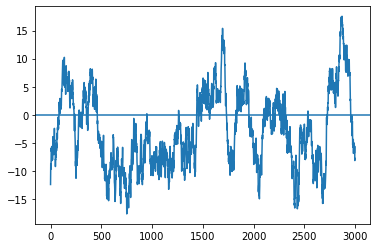

In [143]:
####Generating correlated curves:
np.random.seed(2) 
def gen_correlated_curve(rho, num=100):
    num_with_runup = num+5000
    y = np.zeros((num_with_runup,))
    for i in range(1,num_with_runup):
        y[i] = rho * y[i-1] + np.random.normal()
    return y[-num:]

timeseries = gen_correlated_curve(0.99, 3000)
print(timeseries.mean())
plt.plot(timeseries)
plt.axhline(0)

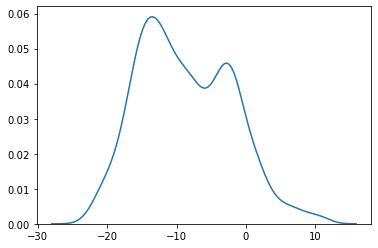

In [147]:
kdeplot(timeseries-6)

In [159]:
((timeseries[:-1]**2).sum() + 1**-2)**-1 * np.dot(timeseries[:-1],timeseries[1:])

0.9899201430232121

In [160]:
pm.summary(trace)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
rho,0.990,0.003,0.984,0.994,0.000,0.000,726.0,725.0,723.0,626.0,1.0
tau,0.933,0.025,0.888,0.979,0.001,0.001,750.0,750.0,771.0,361.0,1.0


In [149]:
with pm.Model() as ar1:
    rho_ = pm.Uniform('rho',-1,1) #we assume process is stationary, so -1<k_<1
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    #center = pm.Normal('center', mu=timeseries.mean(), sigma=5) #set the prior for the true mean initially centred on the population mean
    likelihood = pm.AR1('likelihood', k=rho_, tau_e=tau_, observed=timeseries)
    trace = pm.sample()
    
    

Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1118.40draws/s]


In [140]:
pm.stats.hpd(trace['center'])

array([-9.78340801, -3.36463662])

In [146]:
pm.stats.hpd(trace['rho'])

array([0.99268448, 0.99875802])

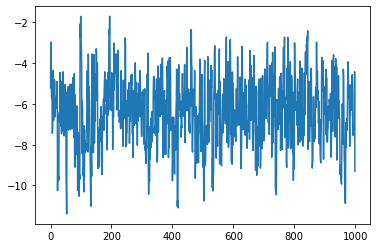

In [141]:
plt.plot(trace['center'])

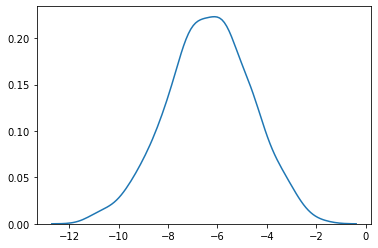

In [142]:
kdeplot(trace['center'])

In [117]:
print(sem_utils.sem_from_blockAveraging(timeseries))
print(sem_utils.sem_from_chodera(timeseries))
print(sem_utils.sem_from_sokal(timeseries))
print(sem_utils.sem_from_independent(timeseries))
print(sem_utils.sem_from_autoregressive_correction(timeseries))
print(pm.stats.hpd(trace['center']))

(-5.522705548090706, 0.10024988156261383)
(-5.771172458391055, 0.34871679186296234)
(-5.183859286742903, -0.23859637978518888)
(-2.9513893584164554, -2.471066308111637)
(-5.896335596446622, 0.47387992991853034)
[ 9.62811075 13.61437933]


In [64]:
with pm.Model() as ar1:
    tau = pm.HalfNormal('tau', sigma=5)
    beta = pm.Uniform('k',-1,1)
    center = pm.Normal('center', mu=timeseries.mean(), sigma=5)
    likelihood = pm.AR('likelihood', beta, sigma=1.0, observed=timeseries-center)
    trace = pm.sample(15000, tune=2000)

Sampling 2 chains, 303 divergences: 100%|██████████| 34000/34000 [00:22<00:00, 1506.82draws/s]
There were 165 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.


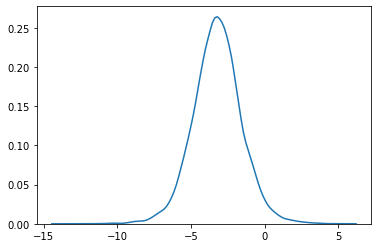

In [65]:
kdeplot(trace['center'])

In [63]:
pm.hpd(trace['center'])

array([-6.47007141, -0.17168066])

In [59]:
mup = ((timeseries[:-1]**2).sum() + tau**-2)**-1 * np.dot(timeseries[:-1],timeseries[1:])
trace['beta'].mean(), mup

(0.9883298218496731, 0.9902859175269698)

In [58]:
pm.hpd(trace['center'])

array([-6.39779851, -0.16277442])

In [53]:
pm.hpd(trace['center'])

array([-6.42276447, -0.15861459])

In [56]:
pm.hpd(trace['center'])

array([-6.68984941, -0.73139645])

In [66]:
 with pm.Model() as ar1:
    k_ = pm.Uniform('k',-1,1) #we assume process is stationary, so -1<k_<1
    tau_ = pm.Gamma('tau',mu=1,sd=1)
    center = pm.Normal('center', mu=timeseries.mean(), sigma=5) #set the prior for the true mean to be centred on the population mean
    likelihood = pm.AR1('likelihood', k=k_, tau_e=tau_, observed=timeseries-center)
    trace = pm.sample()


Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1019.38draws/s]


In [74]:
print(sem_utils.sem_from_blockAveraging(timeseries))
print(sem_utils.sem_from_chodera(timeseries))
print(sem_utils.sem_from_sokal(timeseries))
print(sem_utils.sem_from_independent(timeseries))
print(sem_utils.sem_from_autoregressive_correction(timeseries))
print(pm.stats.hpd(trace['center']))

(-6.036856648996656, -0.3984481450135777)
(-5.808013884252537, -0.6272909097576962)
(-5.379633217690657, -1.0556715763195759)
(-3.440880683421718, -2.994424110588515)
(-6.0908061553193455, -0.3444986386908875)
[-5.30890757 -2.09970676]


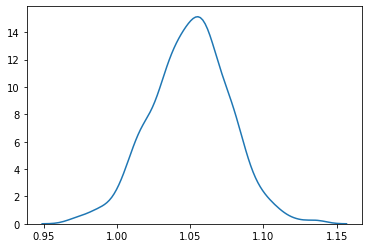

In [67]:
from seaborn import kdeplot
kdeplot(trace['tau'])


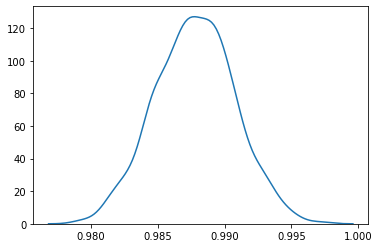

In [38]:
kdeplot(trace['k'])

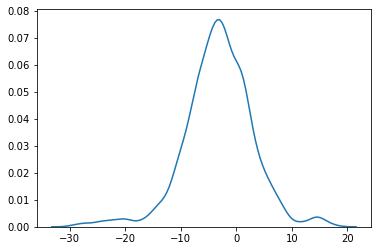

In [40]:
kdeplot(timeseries)

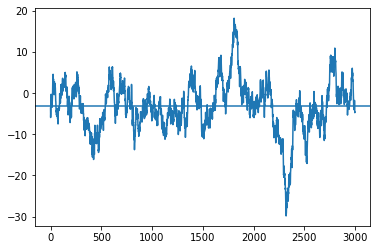

In [39]:
plt.plot(timeseries)
plt.axhline(timeseries.mean())

In [36]:
timeseries.mean()

-3.2176523970051165

In [25]:
from scipy.stats import beta
z95 = 1.959963984540054
results = df.copy()
method_names = results['methodName'].unique()
timeseries_lengths = results['timeSeriesLength'].unique()


#calculate which experiments had the true mean within the estimatimed_mean +/- abs(SEM)
###If using the frequentist CI below, calculate a rate instead of a count:
#results['rate'] = results.apply(lambda row: float(np.abs(row['estMean']) < z95*row['SEM'])*0.01, axis=1)
results['rate'] = results.apply(lambda row: 0.01*float(np.sign(np.array([row['mean_low'], row['mean_high']])).sum()==0), axis=1)


#group by all the experimental conditions, sum the number of correct SEMs per condition,
#then flatten into long format with reset index:
data = pd.DataFrame(results.groupby(['methodName', 'timeSeriesLength', 'trueRho'])['rate'].sum()).reset_index()

#calculate confidence intervals for proportions:
##This uses standard binomial confidence interval:
##(equivalent to from statsmodels.stats.proportion import proportion_confint)
data['confInt'] = data.apply(lambda row: 1.96*np.sqrt(row['rate']*(1-row['rate'])/100), axis=1).fillna(0)

##Alternatively, can calculate the CI using a bayesian conjugate prior (beta distribution)
##I am using a beta(1,1) prior, hence the '+1's. Statsmodels has the Jeffreys interval which uses (0.5,0.5)
data['confIntLow'] = data.apply(lambda row: beta.ppf(0.025, 100*row['rate']+1, 100-100*row['rate']+1), axis=1)
data['confIntHigh'] = data.apply(lambda row: beta.ppf(0.975, 100*row['rate']+1, 100-100*row['rate']+1), axis=1)

In [27]:
import altair as alt
#This is simply to avoid formatting the faceted plot later:
data['trueRho'] =data.apply(lambda row: 'ρ='+str(row['trueRho']),axis=1)

In [28]:
# the base chart
base = alt.Chart(data).transform_calculate(
    x_jittered = '0.15*random()*datum.timeSeriesLength+datum.timeSeriesLength',
     #ymin="datum.rate-datum.confInt",
     #ymax="datum.rate+datum.confInt",
    ymin = "datum.confIntLow",
    ymax = "datum.confIntHigh",
    goal='0.95')



#generate the scatter points:
points = base.mark_point(filled=True).encode(
    x=alt.X('x_jittered:Q', scale=alt.Scale(type='log'), title='Length of Timeseries'),
    y=alt.Y('rate:Q', scale=alt.Scale(domain=[0,1.04]), title='Rate of correct SEM'),
    size=alt.value(80),
    color=alt.Color('methodName', legend=alt.Legend(title="SEM method")))

#generate the scatter points:
line = base.mark_line().encode(
    x=alt.X('x_jittered:Q'),
    y=alt.Y('rate:Q'),
    color='methodName')

# scale=alt.Scale(type='log', domain=[0.001, 1000]),
#           axis=alt.Axis(tickCount=5)
    
#generate the 95% mark:
rule = base.mark_rule(color='black').encode(
    alt.Y('goal:Q'))

# generate the error bars:
# errorbars = base.mark_errorbar().encode(
#     alt.X("x_jittered:Q"),
#     alt.Y("ymin:Q", title=''),
#     alt.Y2("ymax:Q"),
#     color='methodName')

errorbars = base.mark_rule(strokeWidth=3).encode(
    alt.X("x_jittered:Q"),
    alt.Y("ymin:Q", title=''),
    alt.Y2("ymax:Q"),
    color='methodName'
)


selection = alt.selection_single(fields=['symbol']);

chart = alt.layer(
    
  errorbars,
  points,
  line,
  rule,
    
).properties(
    width=250,
    height=200
    ).add_selection(selection).facet(facet=alt.Facet('trueRho:N', 
                                                     title='Autocorrelation parameter (ρ)'), columns=3)


chart = chart.configure_header(titleColor='darkred',
                       titleFontSize=16,
                      labelColor='darkred',
                      labelFontSize=14)

chart = chart.configure_legend(
    strokeColor='gray',
    fillColor='#EEEEEE',
    padding=10,
    cornerRadius=10,
    orient='top'
)


chart

alt.FacetChart(...)